In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install -q git+https://github.com/DeepTrackAI/deeplay.git
# %pip install deeplay
%pip install -q deeptrack --pre
%pip install -q multiprocess

import torch
from rich import print

# Define GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device("cpu"))

print(f"Torch version: {torch.__version__}\nCUDA version: {torch.version.cuda}\nDevice: {device}")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing m

Torch version: 2.3.0+cu121
CUDA version: 12.1
Device: cuda:0

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended texlive-fonts-extra texlive-science 2>/dev/null >/dev/null

In [ ]:
import deeplay as dl
import deeptrack as dt
import torch.nn as nn
import torchvision
import multiprocess as mp
from pathlib import Path
import os
from kornia.contrib import extract_tensor_patches, combine_tensor_patches
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from kornia.utils import tensor_to_image
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from contextlib import contextmanager
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
PLOT_CONTEXT = {
    ##########
    # Figure #
    ##########
    "figure.autolayout": True,
    "figure.subplot.left": 0.5,
    "figure.dpi": 600,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.04,
    # Linewidths
    "axes.linewidth": 0.25,
    "grid.linewidth": 0.25,
    "xtick.major.width": 0.25,
    "xtick.minor.width": 0.25,
    "ytick.major.width": 0.25,
    "ytick.minor.width": 0.25,
    # Plots
    "lines.linewidth": 0.5,
    "lines.markersize": 2,
    "axes.grid": False,
    # Ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.top": True,
    "ytick.right": True,
    # Legend
    "patch.linewidth": 0.25,
    "legend.frameon": True,
    "legend.fancybox": False,
    "legend.loc": "upper left",
    # Colours
    "axes.prop_cycle": "(cycler('color', ['k', 'r', 'b', 'g']) + cycler('ls', ['-', '--', ':', '-.']))",
    ###############
    # Typesetting #
    ###############
    # Title
    "figure.titlesize": 10,
    "figure.titleweight": "bold",
    "axes.titlesize": 9,
    "axes.titleweight": "normal",
    # Axes
    "axes.labelsize": 9,
    "axes.labelweight": "normal",
    # Ticks
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "xtick.major.size" : 3,
    "ytick.major.size" : 3,
    "xtick.minor.size" : 1.5,
    "ytick.minor.size" : 1.5,
    # Legend
    "legend.fontsize": 6,
    "legend.edgecolor": "grey",
    #########
    # LaTeX #
    #########
    "text.usetex": True,  # Use LaTeX
    # LaTeX standard math and physics preamble with sans-serif font in math mode
    "text.latex.preamble": r"""
\usepackage{amsmath}
\usepackage{amssymb}
\usepackage{mathtools}
\usepackage{bbm}
\usepackage{gensymb}
\usepackage[italicdiff]{physics}
\usepackage{icomma}
\usepackage{siunitx}
\sisetup{
  detect-all,
  locale=UK,% Set locale to UK
  output-decimal-marker={,}, % Set comma as decimal separator
  range-phrase=--, % Set range to use "--" instead of " to "
  range-units=single, % Use only a single unit in a range
  per-mode=reciprocal, % Alternatively set to "symbol"
  sticky-per, % Only one \per-command
  bracket-unit-denominator=false, % No parenthesis
  separate-uncertainty=true, % Separate uncertainty with "+/-"
}
\usepackage{sansmath}
\sansmath
\centering
"""
}


mpl.rcParams.update(PLOT_CONTEXT)

In [ ]:
DATA_PATH: Path = Path.cwd() / "data"
DATA_PATH.mkdir(exist_ok=True)
os.environ["DATA_PATH"] = str(DATA_PATH)

mnist_dataset_path: Path = DATA_PATH / "MNIST_dataset" / "mnist"

if not mnist_dataset_path.exists():
    !cd $DATA_PATH && git clone https://github.com/DeepTrackAI/MNIST_dataset

train_files = dt.sources.ImageFolder(
    root=str(mnist_dataset_path / "train"),
)
test_files = dt.sources.ImageFolder(
    root=str(mnist_dataset_path / "test"),
)
files = dt.sources.Join(train_files, test_files)

Cloning into 'MNIST_dataset'...
remote: Enumerating objects: 70019, done.
remote: Counting objects: 100% (70019/70019), done.
remote: Compressing objects: 100% (70014/70014), done.
remote: Total 70019 (delta 4), reused 70008 (delta 2), pack-reused 0
Receiving objects: 100% (70019/70019), 37.33 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (70003/70003), done.


In [ ]:
image_pipeline = (
    dt.LoadImage(files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

label_pipeline = (
    dt.Value(files.label_name[0])
    >> int
)

In [ ]:
train_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=train_files)
test_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline,
                                  inputs=test_files)

n_dataset_workers = mp.cpu_count()
train_loader = dl.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=n_dataset_workers)
test_loader = dl.DataLoader(test_dataset, batch_size=64, shuffle=True,num_workers=n_dataset_workers)

In [ ]:
class Generator(dl.UNet2d):
    def __init__(self, *args, **kwargs):
        self.patch_size = kwargs["channels"][0]
        super().__init__(*args, **kwargs)
        # self[..., "activation"].configure(nn.GELU)

    def forward(self, input):
        _, _, height, width = input.shape
        input.requires_grad_()

        if any(l < self.patch_size for l in (height, width)):
            raise ValueError(
                f"Image ({height}x{width}) is smaller than kernel size ({self.patch_size}x{self.patch_size})"
            )

        stride = [np.gcd(height, self.patch_size), np.gcd(width, self.patch_size)]
        input_patches = extract_tensor_patches(input=input, window_size=self.patch_size, stride=stride).movedim(1, 0)

        output_patches = torch.vmap(super().forward)(input_patches).movedim(0, 1)

        output = combine_tensor_patches(
            patches=output_patches, original_size=(height, width), window_size=self.patch_size, stride=stride
        )

        return output


generator_model = Generator(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=1,
    skip=dl.Cat()
)
# print(generator_model)

In [ ]:
class Discriminator(dl.DeeplayModule):
    def __init__(
            self,
            in_channels,
            hidden_channels_cnn,
            hidden_channels_mlp,
            out_channels_cnn,
            out_features
        ):
        super().__init__()

        self.cnn = dl.ConvolutionalNeuralNetwork(
            in_channels=in_channels,
            hidden_channels=hidden_channels_cnn,
            out_channels=out_channels_cnn,
            pool=nn.MaxPool2d(kernel_size=2),
            out_activation=nn.ReLU,
        )

        self.pool = dl.Layer(nn.MaxPool2d, kernel_size=2)
        self.flatten = dl.Layer(nn.Flatten)

        self.dense = dl.MultiLayerPerceptron(
            in_features=out_channels_cnn,
            hidden_features=hidden_channels_mlp,
            out_features=out_features,
            out_activation=nn.Identity,
        )
        self.dense[..., "layer#0"].configure(nn.LazyLinear)
        # self.dense[..., "activation#-1"] = dl.Layer[nn.Softmax]


    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(self.pool(x))
        x = self.dense(x)

        return torch.sigmoid(x)

discriminator_1 = Discriminator(
    in_channels=1,
    hidden_channels_cnn=[16, 32, 64],
    hidden_channels_mlp=[64, 32],
    out_channels_cnn=64,
    out_features=1
)
discriminator_2 = Discriminator(
    in_channels=1,
    hidden_channels_cnn=[16, 32, 64],
    hidden_channels_mlp=[64, 32],
    out_channels_cnn=64,
    out_features=10
)
# discriminator_2.dense[..., "activation#-1"] = dl.Layer[nn.Softmax]
# print(discriminator_1)
# print(discriminator_2)

In [ ]:
from torchmetrics.functional import accuracy
from torchmetrics.image import StructuralSimilarityIndexMeasure

class GAN(dl.Application):
    def __init__(self, generator, discriminator_1=None, discriminator_2=None, plot_outputs=False, disc_1_loss_w=1, disc_2_loss_w=1, norm_loss_w=1, **kwargs):
        super().__init__(**kwargs)
        # Neural networks
        self.generator = generator
        self.discriminator_1 = discriminator_1
        self.discriminator_2 = discriminator_2

        if not discriminator_1 and not discriminator_2:
            raise ValueError("The GAN must have at least one discriminator")

        # Plot outputs for first batch in every epoch
        self.plot_outputs = plot_outputs

        # Generator loss weights
        self.disc_1_loss_w = disc_1_loss_w
        self.disc_2_loss_w = disc_2_loss_w
        self.norm_loss_w = norm_loss_w

        self.ssim = StructuralSimilarityIndexMeasure()

        self.automatic_optimization = False

    def configure_optimizers(self):
        optimizers, schedulers = [], []

        generator_optimizer = self.create_optimizer_with_params(
            dl.Adam(lr=1e-4,betas=(0.5, 0.999)), self.generator.parameters()
        )
        optimizers.append(generator_optimizer)

        if self.discriminator_1:
            discriminator_1_optimizer = self.create_optimizer_with_params(
                dl.Adam(lr=1e-5), self.discriminator_1.parameters()
            )
            optimizers.append(discriminator_1_optimizer)
            discriminator_1_scheduler = StepLR(discriminator_1_optimizer, step_size=1,gamma=0.8)
            schedulers.append(discriminator_1_scheduler)

        if self.discriminator_2:
            discriminator_2_optimizer = self.create_optimizer_with_params(
                dl.Adam(lr=1e-4), self.discriminator_2.parameters()
            )
            optimizers.append(discriminator_2_optimizer)

        return optimizers, schedulers

    def forward(self, batch):
        return self.generator(batch)

    def plot_training_images(self, batch_tensor, n_plots, name=None):
        fig, axs = plt.subplots(1, n_plots, figsize=((10, n_plots * 10)))

        for i_ax, ax, img in zip(range(n_plots), axs.ravel(), [tensor_to_image(o) for o in batch_tensor[:n_plots].clone().detach()]):
            ax.imshow(img.squeeze(), cmap="gray")

            if name and i_ax == 0:
                ax.set_ylabel(name)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.set_axis_off()


        plt.show()

    def generator_discriminator_1_loss(self, input, target):
        return self.disc_1_loss_w * F.binary_cross_entropy_with_logits(input, target)

    def generator_norm_loss(self, input, target):
        return self.norm_loss_w * F.binary_cross_entropy_with_logits(input, target)

    def generator_discriminator_2_loss(self, input, target):
        # Prepare target
        target_oh = F.one_hot(target, num_classes=10)
        fake_target = torch.zeros_like(input)

        formatted_input = F.softmax(input, dim=1) * target_oh.squeeze(1)

        return self.disc_2_loss_w * torch.sum((formatted_input - fake_target) ** 2.0) / fake_target.shape[0]

    def discriminator_1_loss(self, output_real, output_fake, target_real, target_fake):
        loss_real = F.binary_cross_entropy_with_logits(output_real, target_real)
        loss_fake = F.binary_cross_entropy_with_logits(output_fake, target_fake)

        return (loss_real + loss_fake) / 2

    def discriminator_2_loss(self, input, target):
        return F.binary_cross_entropy(input, target)

    def train_generator(self, optimizer, input, target, batch_idx):
        self.toggle_optimizer(optimizer)

        fake_label = torch.zeros(input.size(0), 1).type_as(input)

        # Feed input into generator
        gen_output = self(input)

        if self.discriminator_1:
            # Feed generated image to discriminator 1
            disc_1_output_fake = self.discriminator_1(gen_output)

            # Prepare target
            real_label = torch.ones(input.size(0), 1).type_as(input)

            # Compute loss
            gen_loss_disc_1 = self.generator_discriminator_1_loss(disc_1_output_fake, real_label)
            self.log("train_gen_loss_disc_1_step", gen_loss_disc_1, prog_bar=True)
            self.log("train_gen_loss_disc_1_epoch", gen_loss_disc_1, prog_bar=True, on_step=False, on_epoch=True)
        else:
            gen_loss_disc_1 = 0

        if self.discriminator_2:
            # Feed generated image to discriminator 2
            disc_2_output_fake = self.discriminator_2(gen_output)

            # Compute loss
            gen_loss_disc_2 = self.generator_discriminator_2_loss(disc_2_output_fake, target)
            self.log("train_gen_loss_disc_2_step", gen_loss_disc_2, prog_bar=True)
            self.log("train_gen_loss_disc_2_epoch", gen_loss_disc_2, prog_bar=True, on_step=False, on_epoch=True)
        else:
            gen_loss_disc_2 = 0

        # Compute norm of pixel difference between input and generator output
        diff = input - gen_output
        norm = torch.norm(diff, dim=(2,3))

        # Compute loss for norm
        gen_loss_norm = self.generator_norm_loss(norm, fake_label)
        self.log("train_gen_loss_norm_step", gen_loss_norm, prog_bar=True)
        self.log("train_gen_loss_norm_epoch", gen_loss_norm, prog_bar=True, on_step=False, on_epoch=True)

        # Compute total generator loss
        gen_loss = gen_loss_disc_2 + gen_loss_disc_1 + gen_loss_norm
        self.log("train_gen_loss_step", gen_loss, prog_bar=True)
        self.log("train_gen_loss_epoch", gen_loss, prog_bar=True, on_step=False, on_epoch=True)

        # Run optimization
        self.manual_backward(gen_loss)
        optimizer.step()
        optimizer.zero_grad()
        self.untoggle_optimizer(optimizer)

        ###############################
        # Print output once per epoch #
        ###############################

        if batch_idx == 0 and self.plot_outputs:
            print(f"[bold]Epoch {self.current_epoch}")
            n_plots = 5

            self.plot_training_images(input, n_plots, "Input image")
            self.plot_training_images(gen_output, n_plots, "Generator output")
            self.plot_training_images(torch.abs(diff), n_plots, "Absolute difference")

            if self.discriminator_1:
                print("Discriminator 1 guess\n", disc_1_output_fake[:5].transpose(0,1))

            if self.discriminator_2:
                print("Discriminator 2 guess (fake)\n", torch.argmax(disc_2_output_fake,dim=1)[:5].unsqueeze(-1).transpose(0,1))

    def train_discriminator_1(self, optimizer, input, output):
        self.toggle_optimizer(optimizer)

        # Feed input into generator
        gen_output = self(input)

        # Feed real input and generator output into discriminator 1
        disc_1_output_real = self.discriminator_1(input)
        disc_1_output_fake = self.discriminator_1(gen_output)

        real_label = torch.ones(input.size(0), 1).type_as(input)
        fake_label = torch.zeros(input.size(0), 1).type_as(input)

        # Compute loss
        disc_1_loss = self.discriminator_1_loss(disc_1_output_real, disc_1_output_fake, real_label, fake_label)
        self.log("train_disc_1_loss_step", disc_1_loss, prog_bar=True)
        self.log("train_disc_1_loss_epoch", disc_1_loss, prog_bar=True, on_step=False, on_epoch=True)

        # Run optimization
        self.manual_backward(disc_1_loss)
        optimizer.step()
        optimizer.zero_grad()
        self.untoggle_optimizer(optimizer)

    def train_discriminator_2(self, optimizer, input, target, batch_idx):
        self.toggle_optimizer(optimizer)

        # Feed input into discriminator directly (only train on real images)
        disc_2_output_real = self.discriminator_2(input)

        # Compute loss
        disc_2_loss = F.cross_entropy(disc_2_output_real, target.squeeze())
        self.log("train_disc_2_loss_step", disc_2_loss, prog_bar=True)
        self.log("train_disc_2_loss_epoch", disc_2_loss, prog_bar=True, on_step=False, on_epoch=True)

        # Run optimization
        self.manual_backward(disc_2_loss)
        optimizer.step()
        optimizer.zero_grad()
        self.untoggle_optimizer(optimizer)

        # Print discriminator 2 guess at start of epoch
        if batch_idx == 0 and self.plot_outputs:
            print("Discriminator 2 guess (real)\n", torch.argmax(disc_2_output_real[:5],dim=1))

    def training_step(self, batch, batch_idx):
        ####################
        # Prepare training #
        ####################

        self.train()

        # Prepare inputs and targets
        input, target = batch

        # Get optimizers
        optimizers = self.optimizers()
        gen_opt = optimizers[0]

        if self.discriminator_1 and self.discriminator_2:
            disc_1_opt = optimizers[1]
            disc_1_sched = self.lr_schedulers()
            disc_2_opt = optimizers[2]
        elif self.discriminator_1 and not self.discriminator_2:
            disc_1_opt = optimizers[1]
            disc_1_sched = self.lr_schedulers()
        else:
            disc_2_opt = optimizers[1]

        # Train generator
        self.train_generator(gen_opt, input, target, batch_idx)

        # Train discriminator 1
        if self.discriminator_1:
            self.train_discriminator_1(disc_1_opt, input, target)

        # Train discriminator 2
        if self.discriminator_2:
            self.train_discriminator_2(disc_2_opt, input, target, batch_idx)

    def test_step(self, batch, batch_idx):
        metrics = {}

        # Prepare inputs and targets
        input, target = batch

        # Feed input into generator
        gen_output = self(input)

        # Compute structural similarity index
        metrics["test_ssim"] = self.ssim(gen_output, input)

        if self.discriminator_1:
            # Feed real input and generator output into discriminator 1
            disc_1_output_real = self.discriminator_1(input)
            disc_1_output_fake = self.discriminator_1(gen_output)

            real_label = torch.ones(input.size(0), 1).type_as(input)
            fake_label = torch.zeros(input.size(0), 1).type_as(input)

            # Compute accuracies
            metrics["test_accuracy_discriminator_1_real"] = accuracy(torch.round(disc_1_output_real), real_label, task="binary")
            metrics["test_accuracy_discriminator_1_fake"] = accuracy(torch.round(disc_1_output_fake), fake_label, task="binary")
            metrics["test_accuracy_discriminator_1_total"] = accuracy(torch.round(torch.cat((disc_1_output_real, disc_1_output_fake), dim=0)), torch.cat((real_label, fake_label), dim=0), task="binary")

        if self.discriminator_2:
            disc_2_output_real = self.discriminator_2(input)
            disc_2_output_fake = self.discriminator_2(gen_output)

            # Compute accuracy
            metrics["test_accuracy_discriminator_2_real"] = accuracy(torch.argmax(disc_2_output_real,dim=1).unsqueeze(-1), target, task="multiclass", num_classes=10)
            metrics["test_accuracy_discriminator_2_fake"] = accuracy(torch.argmax(disc_2_output_fake,dim=1).unsqueeze(-1), target, task="multiclass", num_classes=10)

        self.log_dict(metrics)

        return metrics


gan = GAN(
    generator=generator_model.create(),
    discriminator_1=discriminator_1.create(),
    discriminator_2=discriminator_2.create(),
    disc_1_loss_w=2,
    disc_2_loss_w=100,
    norm_loss_w=0.5,
    plot_outputs=True
)
print(gan)

GAN(
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (generator): Generator(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
      (postprocess): Identity()
    )
    (bottleneck): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
        )
      )
    )
    (decoder): ConvolutionalDecoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
        )
        (1): Conv2dBlock(
          (layer): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (upsample): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
        )
        (2): Conv2dBlock(
          (layer): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): Identity()
        )
      )
      (preprocess): Identity()
    )
    (skip): Cat()
  )
  (discriminator_1): Discriminator(
    (cnn): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (3): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): LazyLinear(in_features=0, out_features=64, bias=True)
          (activation): ReLU()
        )
        (1): LinearBlock(
          (layer): Linear(in_features=64, out_features=32, bias=True)
          (activation): ReLU()
        )
        (2): LinearBlock(
          (layer): Linear(in_features=32, out_features=1, bias=True)
          (activation): Identity()
        )
      )
    )
  )
  (discriminator_2): Discriminator(
    (cnn): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
   

In [ ]:
from torchsummary import summary

print("[bold]Generator")
summary(gan.generator, (1, 28, 28), device="cpu")
print("[bold]Discriminator 1")
summary(gan.discriminator_1, (1, 28, 28), device="cpu")
print("[bold]Discriminator 2")
summary(gan.discriminator_2, (1, 28, 28), device="cpu")

Generator

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             160
              ReLU-2           [-1, 16, 16, 16]               0
       Conv2dBlock-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
              ReLU-6             [-1, 32, 8, 8]               0
       Conv2dBlock-7             [-1, 32, 8, 8]               0
         MaxPool2d-8             [-1, 32, 4, 4]               0
            Conv2d-9             [-1, 64, 4, 4]          18,496
             ReLU-10             [-1, 64, 4, 4]               0
      Conv2dBlock-11             [-1, 64, 4, 4]               0
         Identity-12             [-1, 64, 4, 4]               0
        MaxPool2d-13             [-1, 64, 2, 2]               0
           Conv2d-14             [-1, 6

Discriminator 1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       Conv2dBlock-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
         MaxPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           4,640
              ReLU-8           [-1, 32, 14, 14]               0
       Conv2dBlock-9           [-1, 32, 14, 14]               0
        MaxPool2d-10             [-1, 32, 7, 7]               0
        MaxPool2d-11             [-1, 32, 7, 7]               0
        MaxPool2d-12             [-1, 32, 7, 7]               0
           Conv2d-13             [-1, 64, 7, 7]          18,496
             ReLU-14             [-1, 6

Discriminator 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       Conv2dBlock-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
         MaxPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           4,640
              ReLU-8           [-1, 32, 14, 14]               0
       Conv2dBlock-9           [-1, 32, 14, 14]               0
        MaxPool2d-10             [-1, 32, 7, 7]               0
        MaxPool2d-11             [-1, 32, 7, 7]               0
        MaxPool2d-12             [-1, 32, 7, 7]               0
           Conv2d-13             [-1, 64, 7, 7]          18,496
             ReLU-14             [-1, 6

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name            ┃ Type                             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ train_metrics   │ MetricCollection                 │      0 │
│ 1 │ val_metrics     │ MetricCollection                 │      0 │
│ 2 │ test_metrics    │ MetricCollection                 │      0 │
│ 3 │ generator       │ Generator                        │  128 K │
│ 4 │ discriminator_1 │ Discriminator                    │ 62.3 K │
│ 5 │ discriminator_2 │ Discriminator                    │ 62.6 K │
│ 6 │ ssim            │ StructuralSimilarityIndexMeasure │      0 │
└───┴─────────────────┴──────────────────────────────────┴────────┘

Trainable params: 253 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 253 K                                                                                                
Total estimated model params size (MB): 1

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

Epoch 0

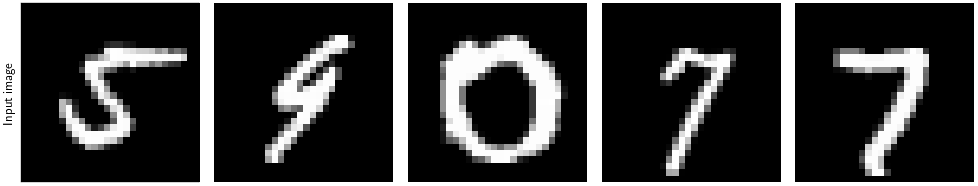

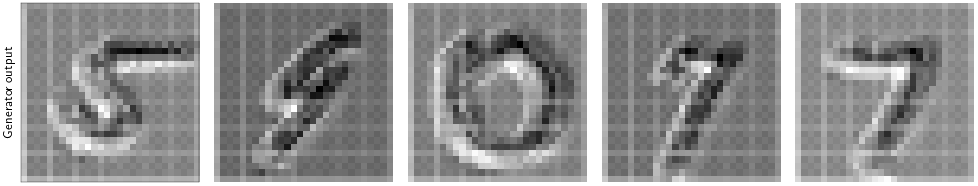

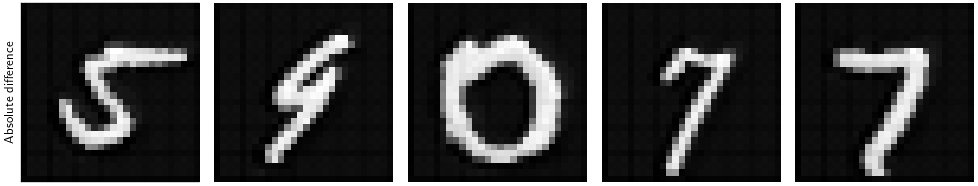

Discriminator 1 guess
 tensor([[0.5071, 0.5071, 0.5072, 0.5071, 0.5071]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[2, 2, 2, 2, 2]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([2, 2, 2, 2, 2], device='cuda:0')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1

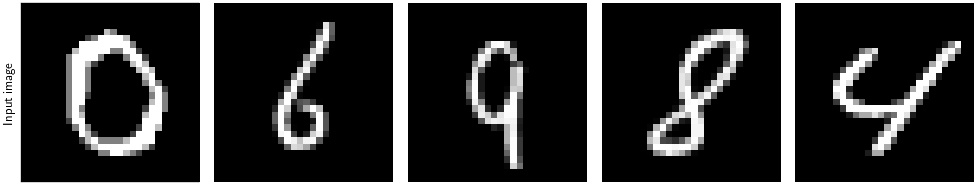

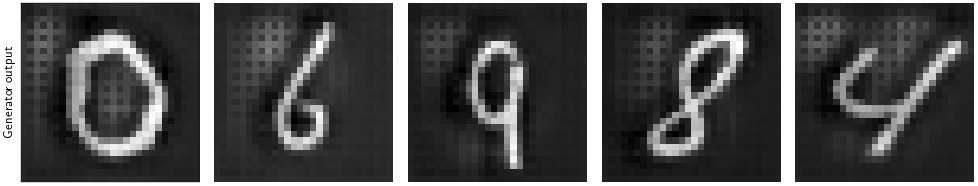

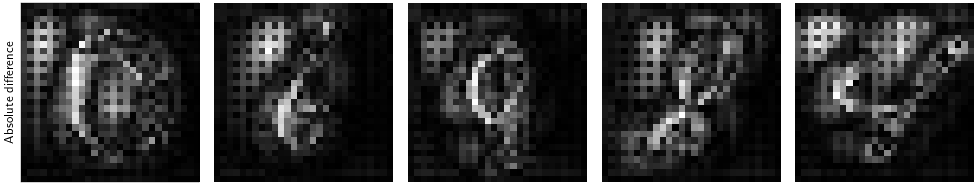

Discriminator 1 guess
 tensor([[0.4701, 0.4771, 0.4850, 0.4813, 0.4759]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[3, 3, 2, 3, 2]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([0, 6, 9, 8, 4], device='cuda:0')

Epoch 2

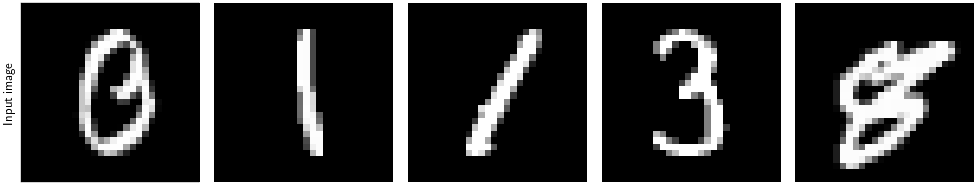

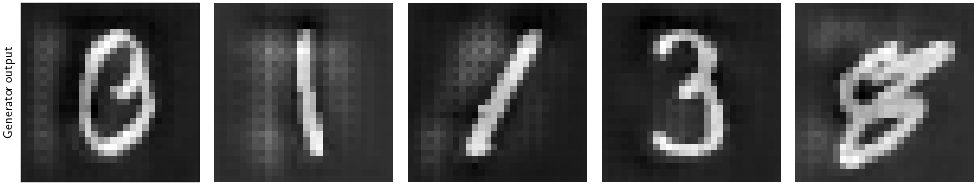

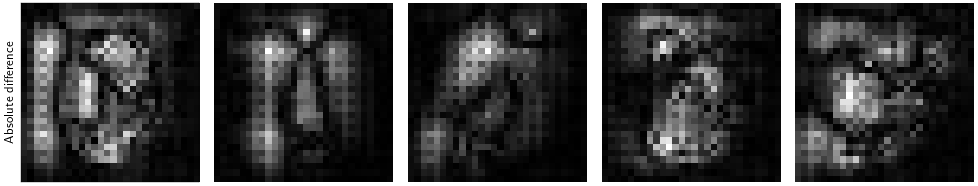

Discriminator 1 guess
 tensor([[0.0891, 0.1376, 0.1599, 0.1883, 0.2834]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[3, 3, 3, 3, 3]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([8, 1, 1, 3, 8], device='cuda:0')

Epoch 3

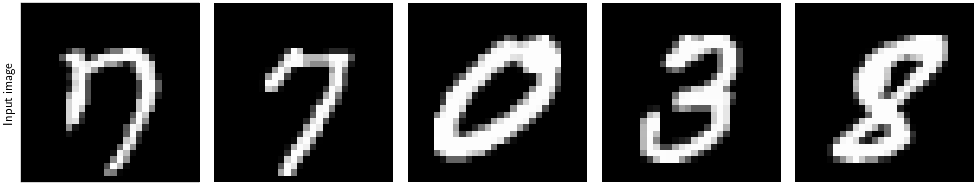

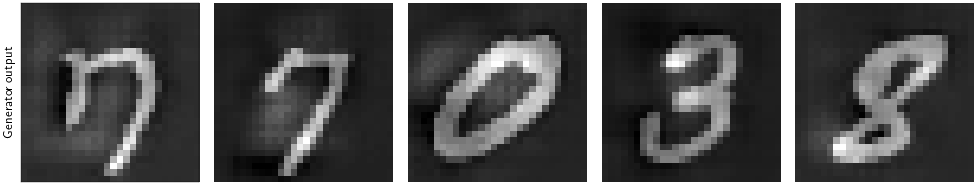

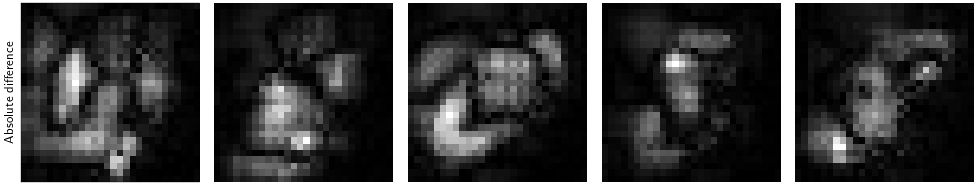

Discriminator 1 guess
 tensor([[0.0328, 0.2080, 0.0096, 0.0858, 0.1948]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[0, 0, 7, 8, 0]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([7, 7, 0, 3, 8], device='cuda:0')

Epoch 4

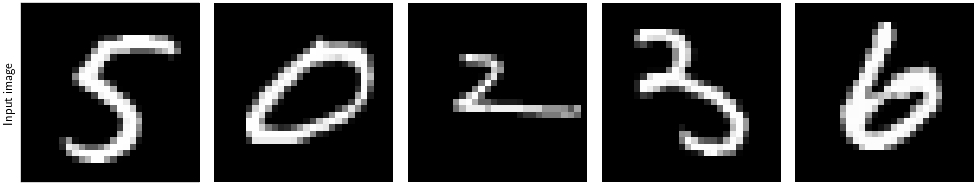

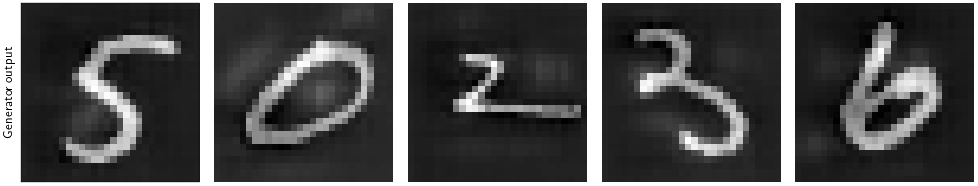

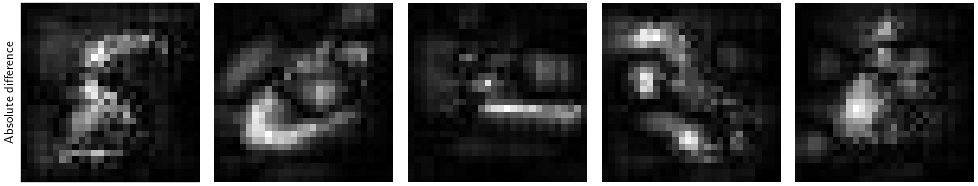

Discriminator 1 guess
 tensor([[0.4511, 0.0162, 0.1772, 0.5809, 0.0453]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 0, 4, 6, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([8, 0, 4, 3, 6], device='cuda:0')

Epoch 5

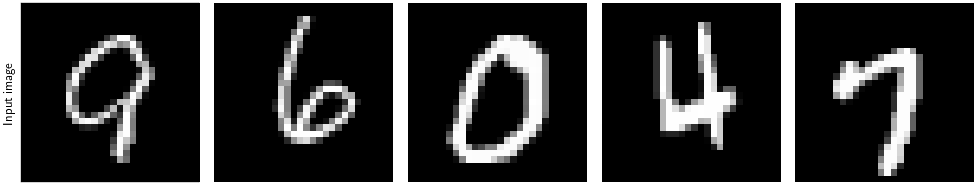

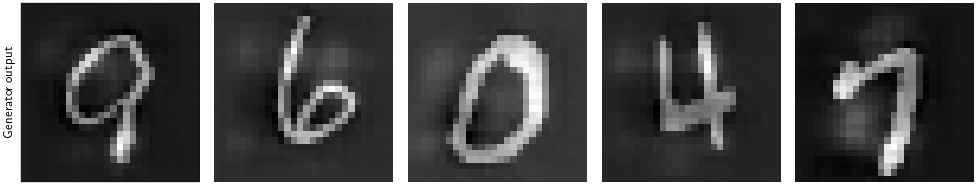

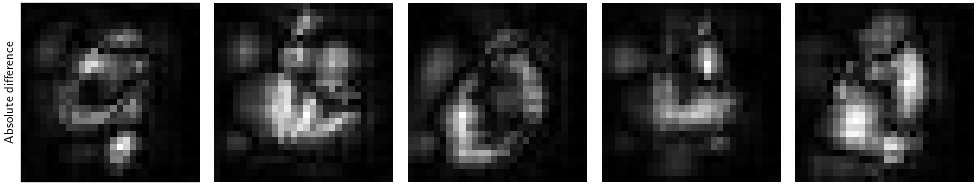

Discriminator 1 guess
 tensor([[0.0338, 0.0176, 0.0134, 0.0085, 0.1888]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[7, 8, 7, 3, 4]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([9, 6, 0, 4, 7], device='cuda:0')

Epoch 6

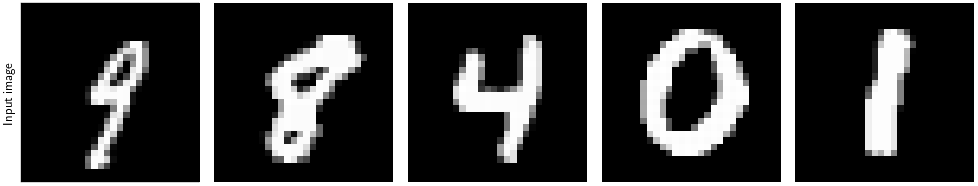

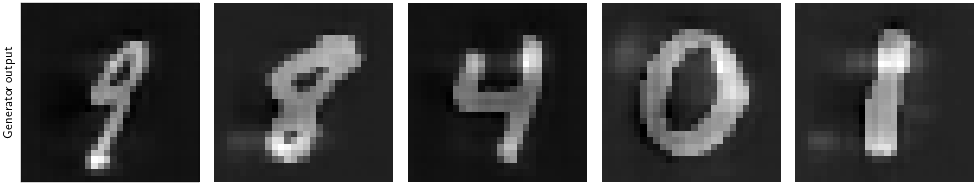

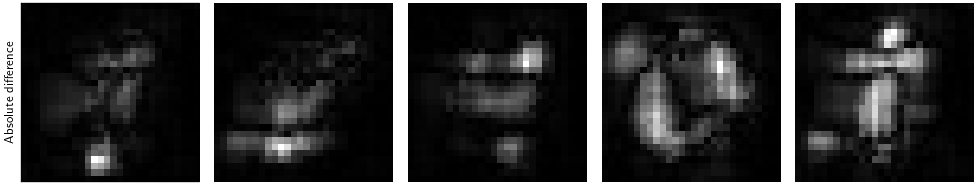

Discriminator 1 guess
 tensor([[0.5251, 0.1227, 0.8775, 0.0420, 0.1238]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 8, 7, 0, 3]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([9, 8, 4, 0, 1], device='cuda:0')

Epoch 7

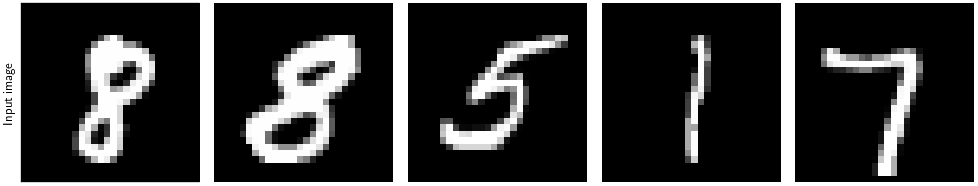

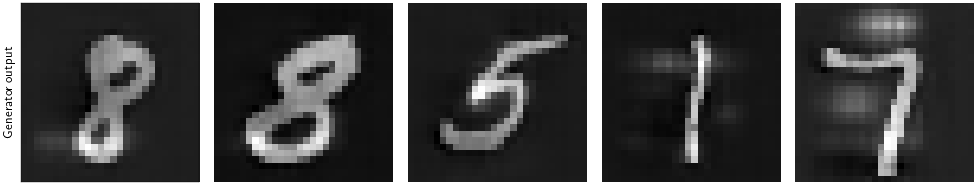

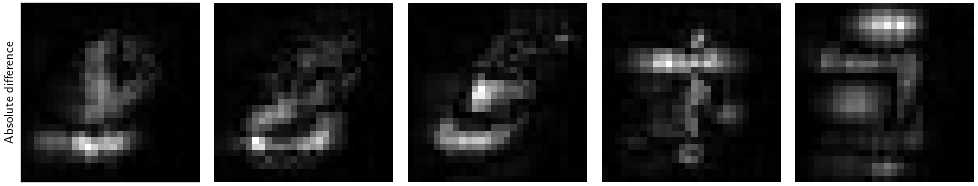

Discriminator 1 guess
 tensor([[0.0804, 0.2576, 0.2987, 0.1693, 0.0069]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[2, 8, 9, 7, 3]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([8, 8, 3, 1, 7], device='cuda:0')

Epoch 8

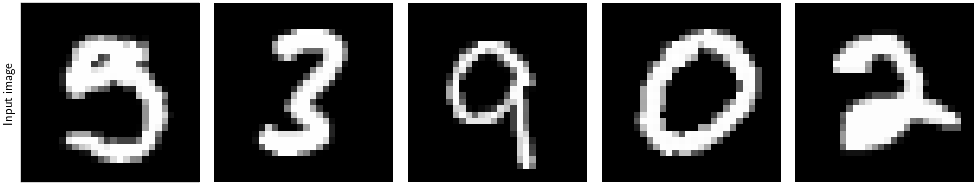

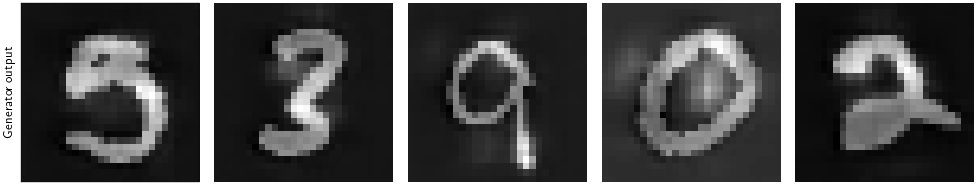

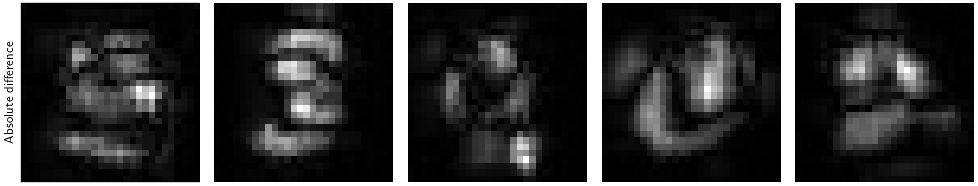

Discriminator 1 guess
 tensor([[0.1269, 0.0661, 0.0212, 0.0004, 0.1089]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 8, 3, 3, 3]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([3, 2, 9, 0, 2], device='cuda:0')

Epoch 9

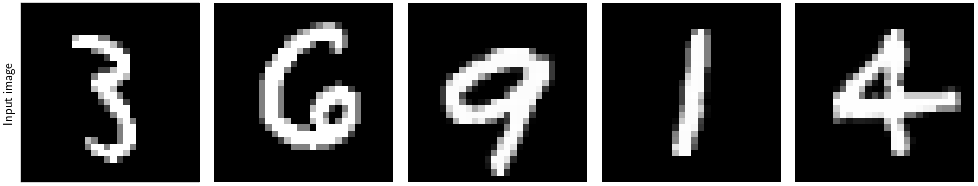

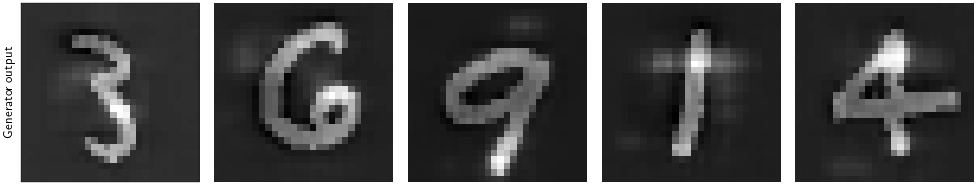

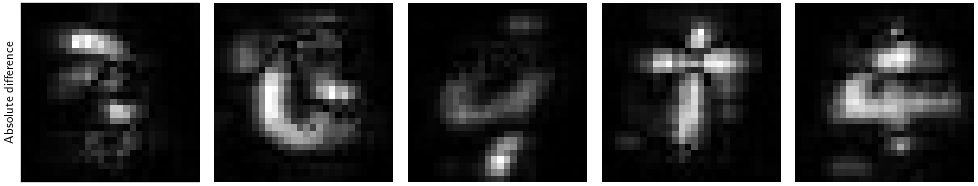

Discriminator 1 guess
 tensor([[0.0108, 0.0208, 0.0115, 0.0081, 0.0093]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[9, 8, 7, 7, 3]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([3, 6, 9, 1, 4], device='cuda:0')

Epoch 10

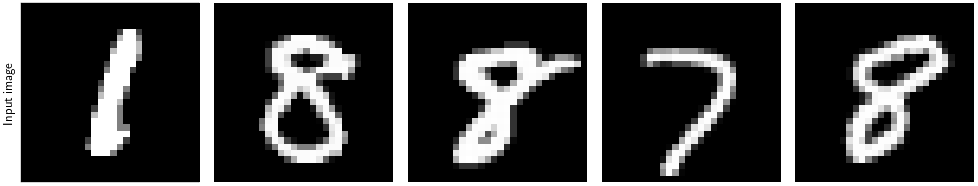

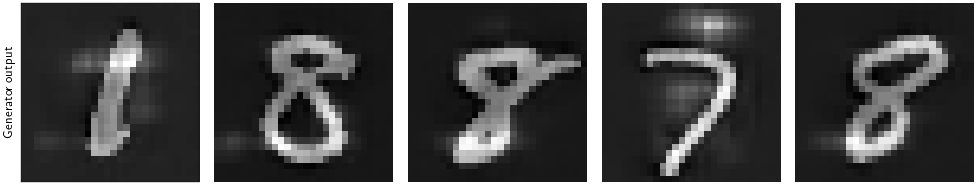

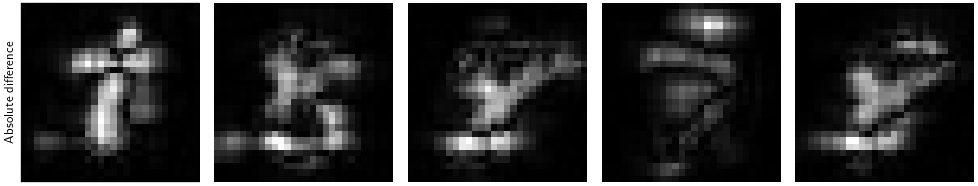

Discriminator 1 guess
 tensor([[0.0024, 0.0100, 0.0039, 0.0049, 0.0053]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[3, 3, 2, 3, 2]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([1, 8, 8, 7, 8], device='cuda:0')

Epoch 11

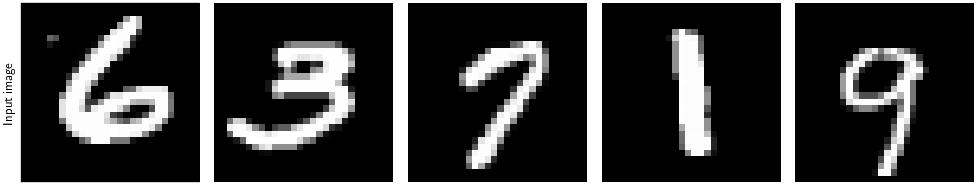

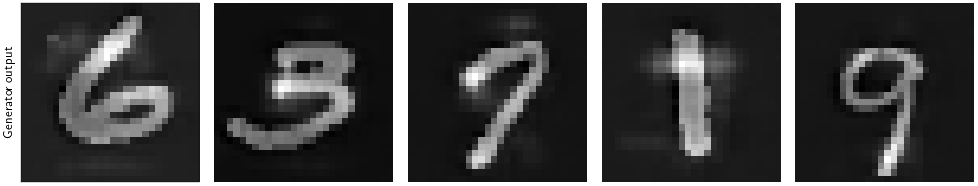

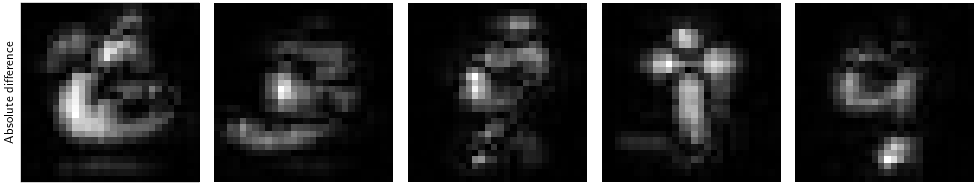

Discriminator 1 guess
 tensor([[0.0021, 0.0171, 0.0989, 0.0026, 0.1326]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 9, 9, 3, 7]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([6, 3, 7, 1, 9], device='cuda:0')

Epoch 12

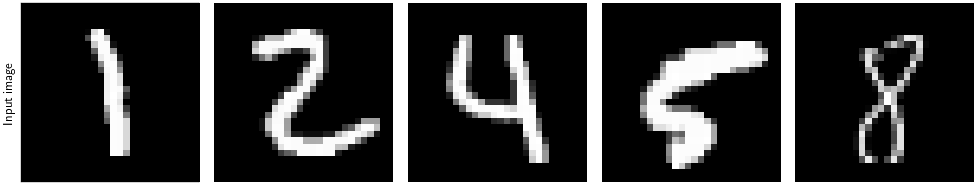

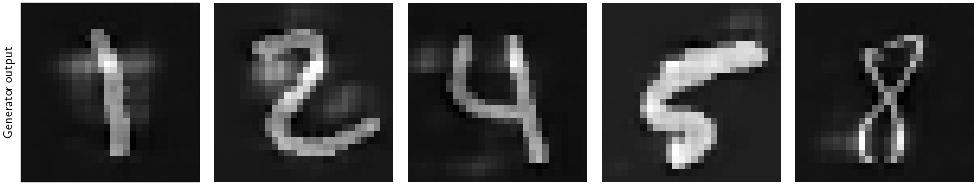

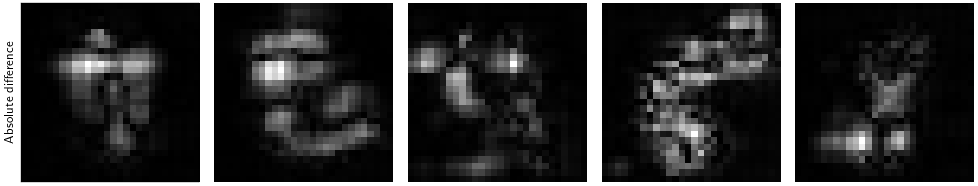

Discriminator 1 guess
 tensor([[0.0014, 0.0009, 0.0019, 0.0158, 0.0027]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[7, 8, 9, 0, 2]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([1, 2, 4, 8, 8], device='cuda:0')

Epoch 13

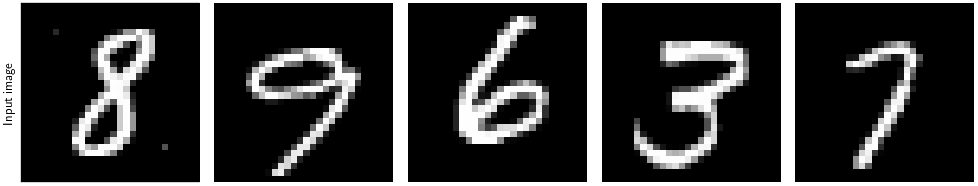

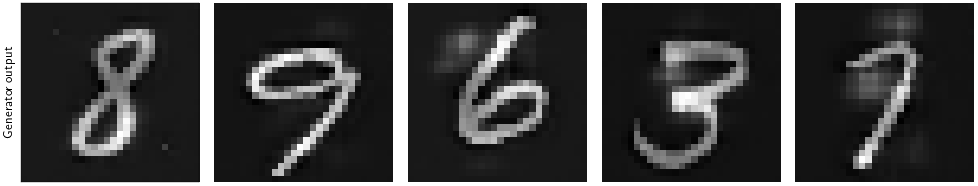

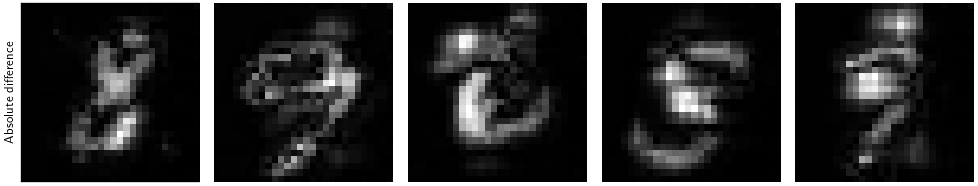

Discriminator 1 guess
 tensor([[0.6586, 0.2470, 0.0007, 0.1146, 0.0040]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[2, 7, 8, 9, 9]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([8, 9, 6, 3, 7], device='cuda:0')

Epoch 14

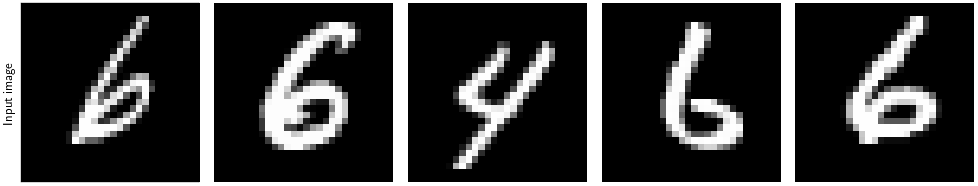

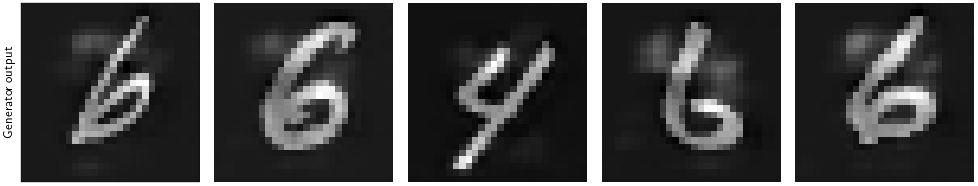

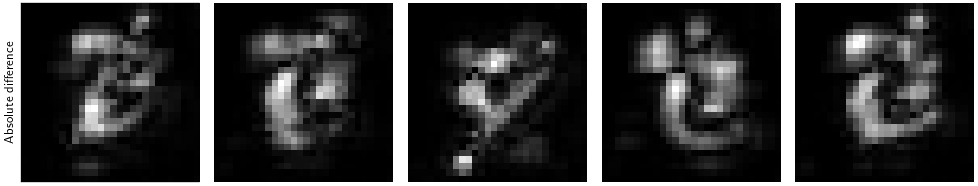

Discriminator 1 guess
 tensor([[0.0022, 0.0006, 0.0143, 0.0004, 0.0007]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 8, 7, 8, 8]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([6, 6, 4, 6, 6], device='cuda:0')

Epoch 15

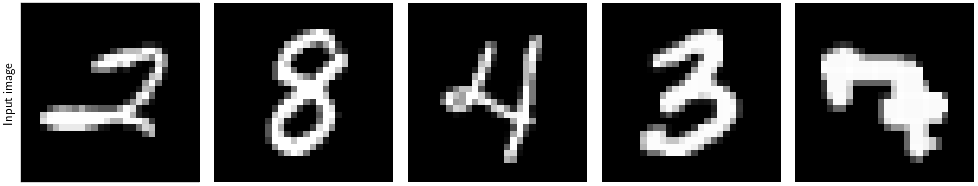

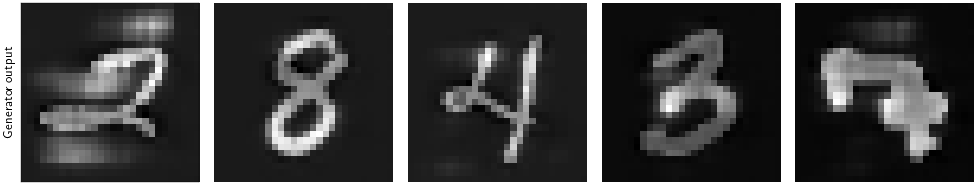

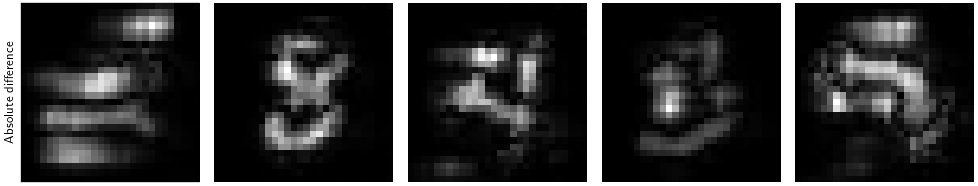

Discriminator 1 guess
 tensor([[1.8011e-04, 8.2727e-01, 4.1992e-02, 5.5926e-02, 3.6443e-02]],
       device='cuda:0', grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 2, 7, 8, 4]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([2, 8, 4, 3, 7], device='cuda:0')

Epoch 16

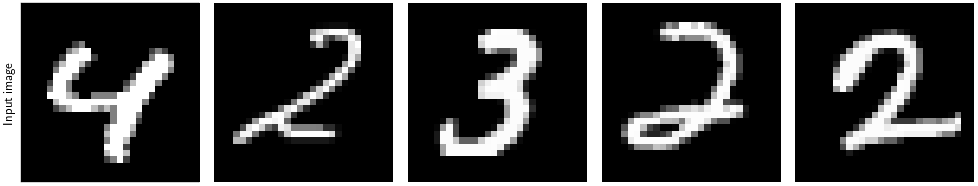

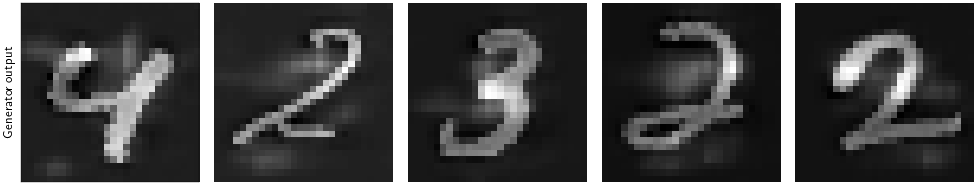

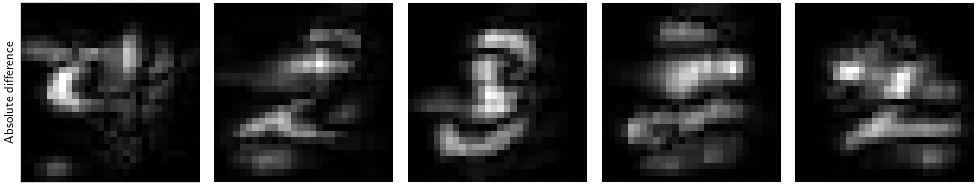

Discriminator 1 guess
 tensor([[0.0006, 0.0005, 0.0002, 0.0001, 0.0371]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[7, 8, 9, 3, 9]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([4, 2, 3, 2, 2], device='cuda:0')

Epoch 17

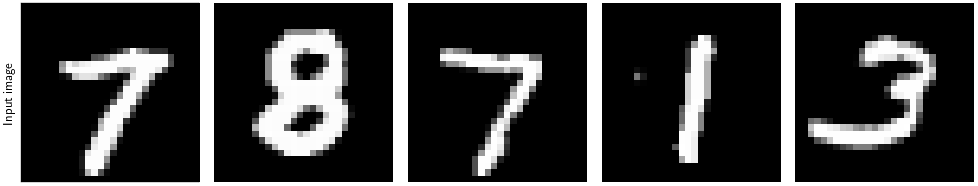

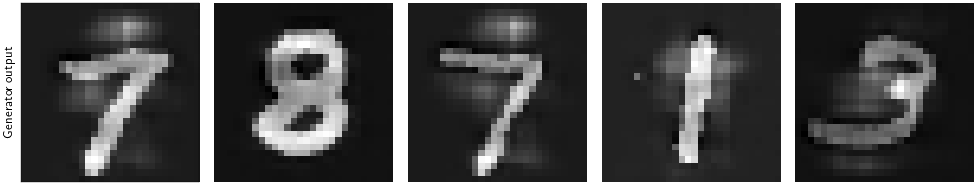

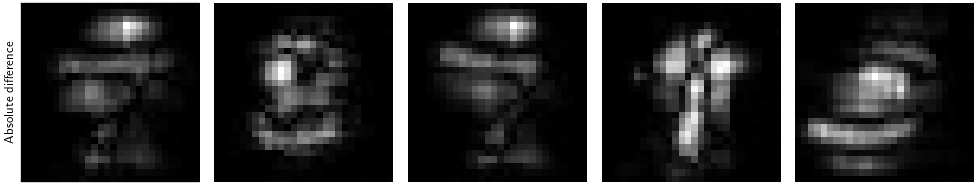

Discriminator 1 guess
 tensor([[3.0861e-04, 5.1812e-01, 3.2200e-04, 8.4359e-04, 5.1677e-05]],
       device='cuda:0', grad_fn=<TransposeBackward0>)

Discriminator 2 guess (fake)
 tensor([[8, 2, 3, 9, 9]], device='cuda:0')

Discriminator 2 guess (real)
 tensor([7, 8, 7, 1, 3], device='cuda:0')

KeyboardInterrupt: 

In [ ]:
from deeplay.callbacks import LogHistory
from lightning.pytorch.loggers import CSVLogger
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
mpl.rcParams.update({"figure.dpi":100})

logger = CSVLogger(save_dir=RESULTS_DIR, name=f"gan_full_logs")
training_history = LogHistory()
trainer = dl.Trainer(max_epochs=100, callbacks=[training_history], logger=logger)
trainer.fit(gan, train_loader)

(<Figure size 1500x1500 with 9 Axes>,
 array([[<Axes: title={'center': 'Gen loss disc 1'}, xlabel='Step'>,
         <Axes: title={'center': 'Gen loss disc 2'}, xlabel='Step'>,
         <Axes: title={'center': 'Gen loss norm'}, xlabel='Step'>],
        [<Axes: title={'center': 'Gen loss'}, xlabel='Step'>,
         <Axes: title={'center': 'Disc 1 loss'}, xlabel='Step'>,
         <Axes: title={'center': 'Disc 2 loss'}, xlabel='Step'>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

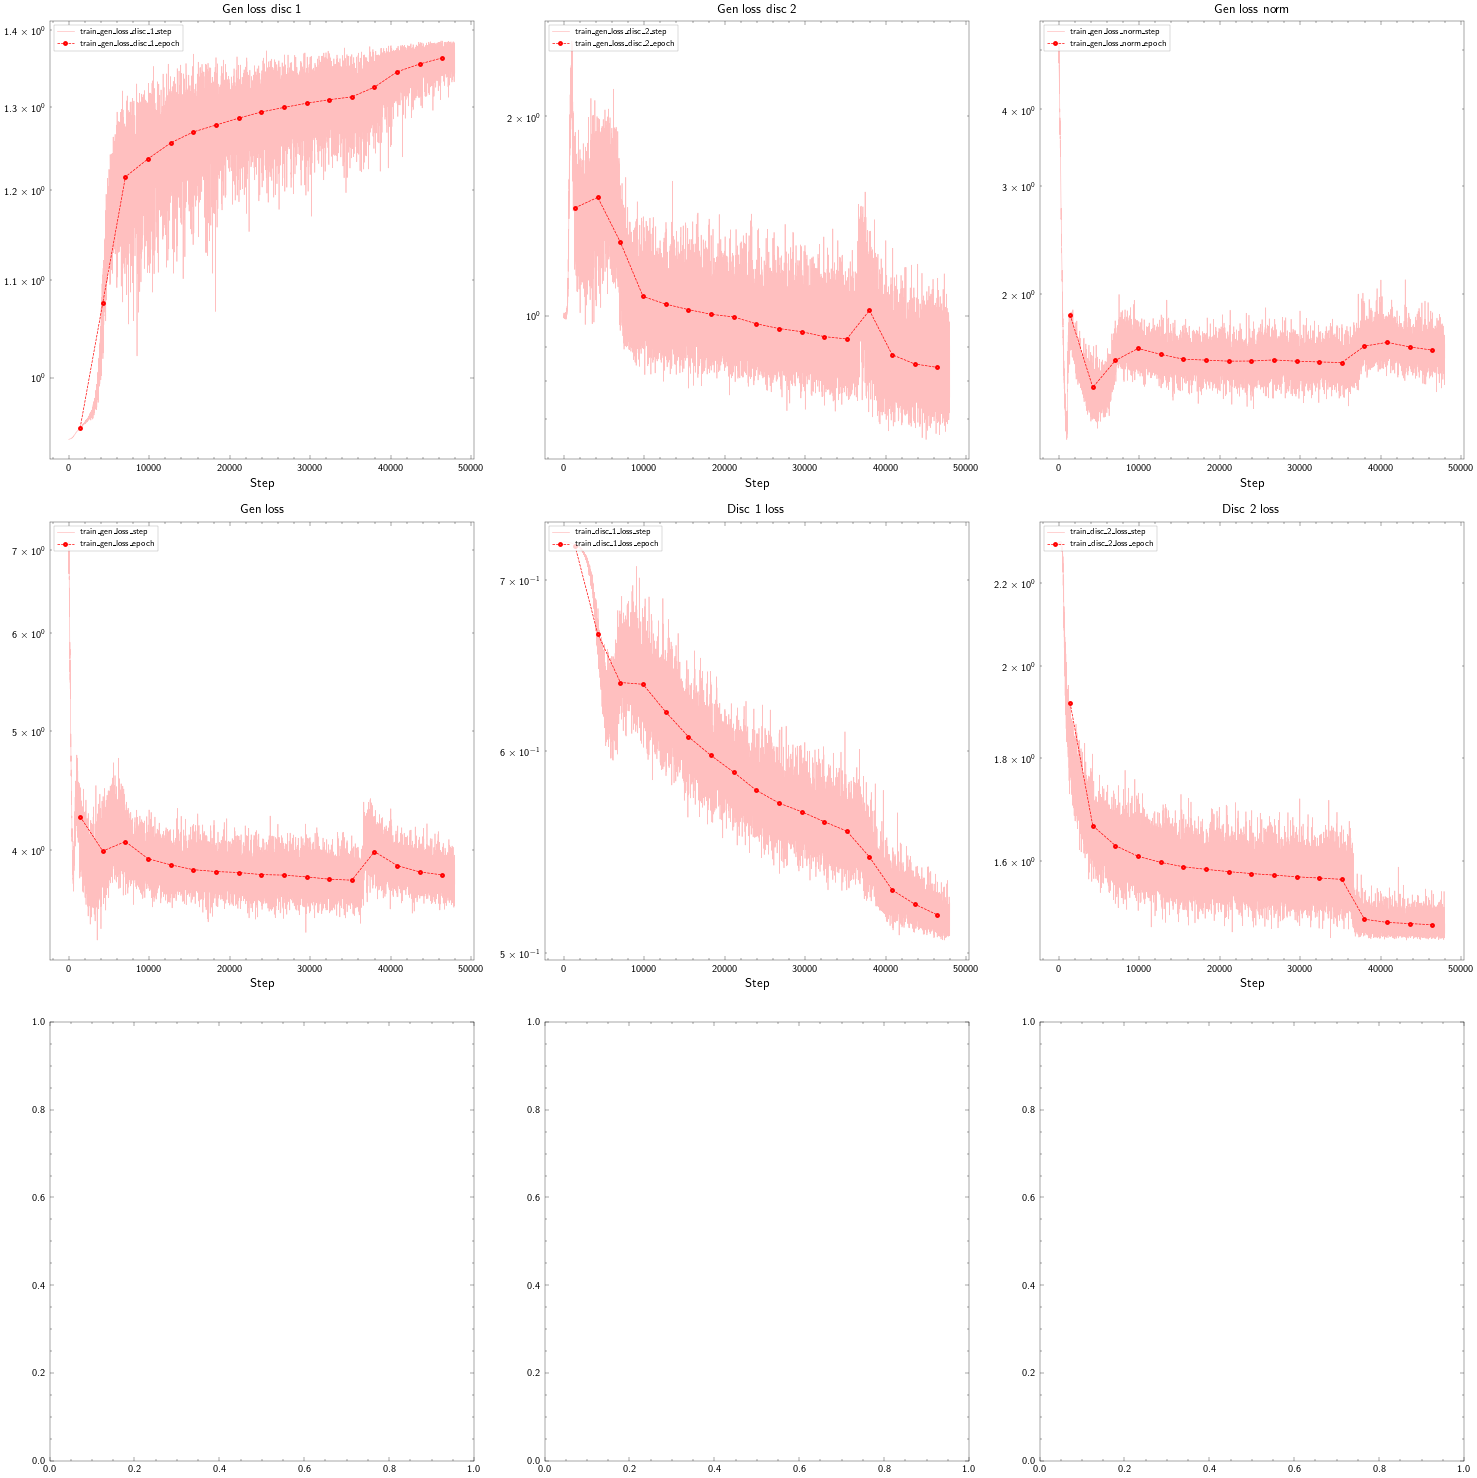

In [ ]:
training_history.plot()

In [ ]:
trainer.test(gan, test_loader)

Output()

AssertionError: 

In [ ]:
mpl.rcParams.update({"figure.dpi":600})

In [ ]:
import pandas as pd
from lightning.pytorch.loggers import CSVLogger

EXPERIMENT_1_DIR = Path("gan_experiment_1")
EXPERIMENT_1_DIR.mkdir(exist_ok=True, parents=True)

def run_gan_experiment_discriminator_1():
    n_epochs = 50
    n_runs = 10
    norm_loss_w = 1
    disc_1_norm_loss_w_ratio_arr = np.geomspace(1e-2, 1e2, n_runs)
    disc_1_loss_w_arr = disc_1_norm_loss_w_ratio_arr
    sum_arr = disc_1_loss_w_arr + norm_loss_w
    disc_1_loss_w_arr /= sum
    norm_loss_w /= sum

    test_metrics_dcts = []

    for i_run, disc_1_loss_w, disc_1_norm_loss_w_ratio in zip(range(len(disc_1_loss_w_arr)), disc_1_loss_w_arr, disc_1_norm_loss_w_ratio_arr):
        gan = GAN(
            generator=generator_model.create(),
            discriminator_1=discriminator_1.create(),
            disc_1_loss_w=disc_1_loss_w,
            norm_loss_w=norm_loss_w
        )

        logger = CSVLogger(save_dir=EXPERIMENT_1_DIR, name=f"gan_disc_1_{i_run}_{disc_1_loss_w}_logs")
        trainer = dl.Trainer(max_epochs=n_epochs, logger=logger)
        trainer.fit(gan, train_loader)
        torch.save(gan.state_dict(),  EXPERIMENT_1_DIR / f"gan_disc_1_{i_run}_{disc_1_loss_w}.pth")

        test_metrics = trainer.test(gan, test_loader)[0]
        test_metrics["disc_1_loss_w"] = disc_1_loss_w
        test_metrics["norm_loss_w"] = norm_loss_w
        test_metrics["disc_1_norm_loss_w_ratio"] = disc_1_norm_loss_w_ratio
        test_metrics["epochs"] = n_epochs

        test_metrics_dcts.append(test_metrics)

    return pd.DataFrame(test_metrics_dcts)



experiment_1_metrics_df = run_gan_experiment_discriminator_1()
experiment_1_metrics_df.to_csv(EXPERIMENT_1_DIR / "test_metrics.csv", sep=",")

UFuncTypeError: Cannot cast ufunc 'divide' output from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [ ]:
os.environ["EXPERIMENT_1_DIR"] = str(EXPERIMENT_1_DIR)
os.environ["EXPERIMENT_1_ZIP_FILE"] = "gan_experiment_1.zip"
!zip -r ${EXPERIMENT_1_ZIP_FILE} ${EXPERIMENT_1_DIR}
!cp -r ${EXPERIMENT_1_ZIP_FILE} /content/drive/MyDrive/${EXPERIMENT_1_ZIP_FILE}

In [ ]:
experiment_1_metrics_df

,test_ssim,test_accuracy_discriminator_1_real,test_accuracy_discriminator_1_fake,test_accuracy_discriminator_1_total,disc_1_loss_w,norm_loss_w,disc_1_norm_loss_w_ratio,epochs
0,0.747467,1.0,0.0,0.5,0.005,0.5,0.01,1
1,0.628228,1.0,0.0,0.5,50.000,0.5,100.00,1


## Warp images for model architecture graph

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import kornia as K

In [ ]:
WARPED_IMAGES_DIR = Path("warped_images")
WARPED_IMAGES_DIR.mkdir(exist_ok=True)

def warp_image(image, height_factor, width_factor, scaling_factor):
    # Rezise image for warping, but keep image pixelated
    image = cv2.resize(image, tuple(np.array(image.shape[:2])*scaling_factor), interpolation = cv2.INTER_NEAREST)

    height,width = image.shape
    height_max = height-1
    width_max = width -1
    height_factor = 0.9
    width_factor = 0.5
    new_height = int(height * height_factor)
    new_width = int(width * width_factor)
    height_diff = height - new_height
    width_diff = width - new_width

    # Change image formate to introduce transparency
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGRA)*255

    # Define warp points (old and new positions)
    points_1 = np.float32([[0,0],[0,height_max],[width_max,0],[width_max,height_max]])
    points_2 = np.float32([[0,height_diff],[0,height_max],[width_max-width_diff,0],[width_max-width_diff,height_max-height_diff]])

    # Compute transformation matrix
    transform_mat = cv2.getPerspectiveTransform(points_1,points_2)

    # Perform warping
    dst = cv2.warpPerspective(image,transform_mat,(width, height))

    # Crop warped image
    dst = dst[:,:new_width]

    return dst


def generate_plot_warped_images(gan, n_images):
    height_factor = 0.9
    width_factor = 0.6
    scaling_factor = 20

    for i_batch, batch in enumerate(test_loader):
        input, target = batch
        gen_output = gan.generator(input[:n_images])

        for i_plot in range(n_images):
            input_image = tensor_to_image(input[i_plot])
            gen_image = tensor_to_image(gen_output[i_plot])

            warped_input_image = warp_image(input_image, height_factor, width_factor, scaling_factor)
            warped_gen_image = warp_image(gen_image, height_factor, width_factor, scaling_factor)

            input_image_resized = cv2.resize(input_image, tuple(np.array(input_image.shape[:2])*scaling_factor), interpolation = cv2.INTER_NEAREST)
            gen_image_resized =cv2.resize(gen_image, tuple(np.array(gen_image.shape[:2])*scaling_factor), interpolation = cv2.INTER_NEAREST)
            cv2.imwrite(str(WARPED_IMAGES_DIR/f"mnist_{i_plot}_digit_{target[i_plot].item()}.png"), input_image_resized*255)
            cv2.imwrite(str(WARPED_IMAGES_DIR/f"gen_mnist_{i_plot}_digit_{target[i_plot].item()}.png"), gen_image_resized*255)
            cv2.imwrite(str(WARPED_IMAGES_DIR/f"warped_mnist_{i_plot}_digit_{target[i_plot].item()}.png"), warped_input_image)
            cv2.imwrite(str(WARPED_IMAGES_DIR/f"warped_gen_mnist_{i_plot}_digit_{target[i_plot].item()}.png"), warped_gen_image)

        break

generate_plot_warped_images(gan, n_images=10)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


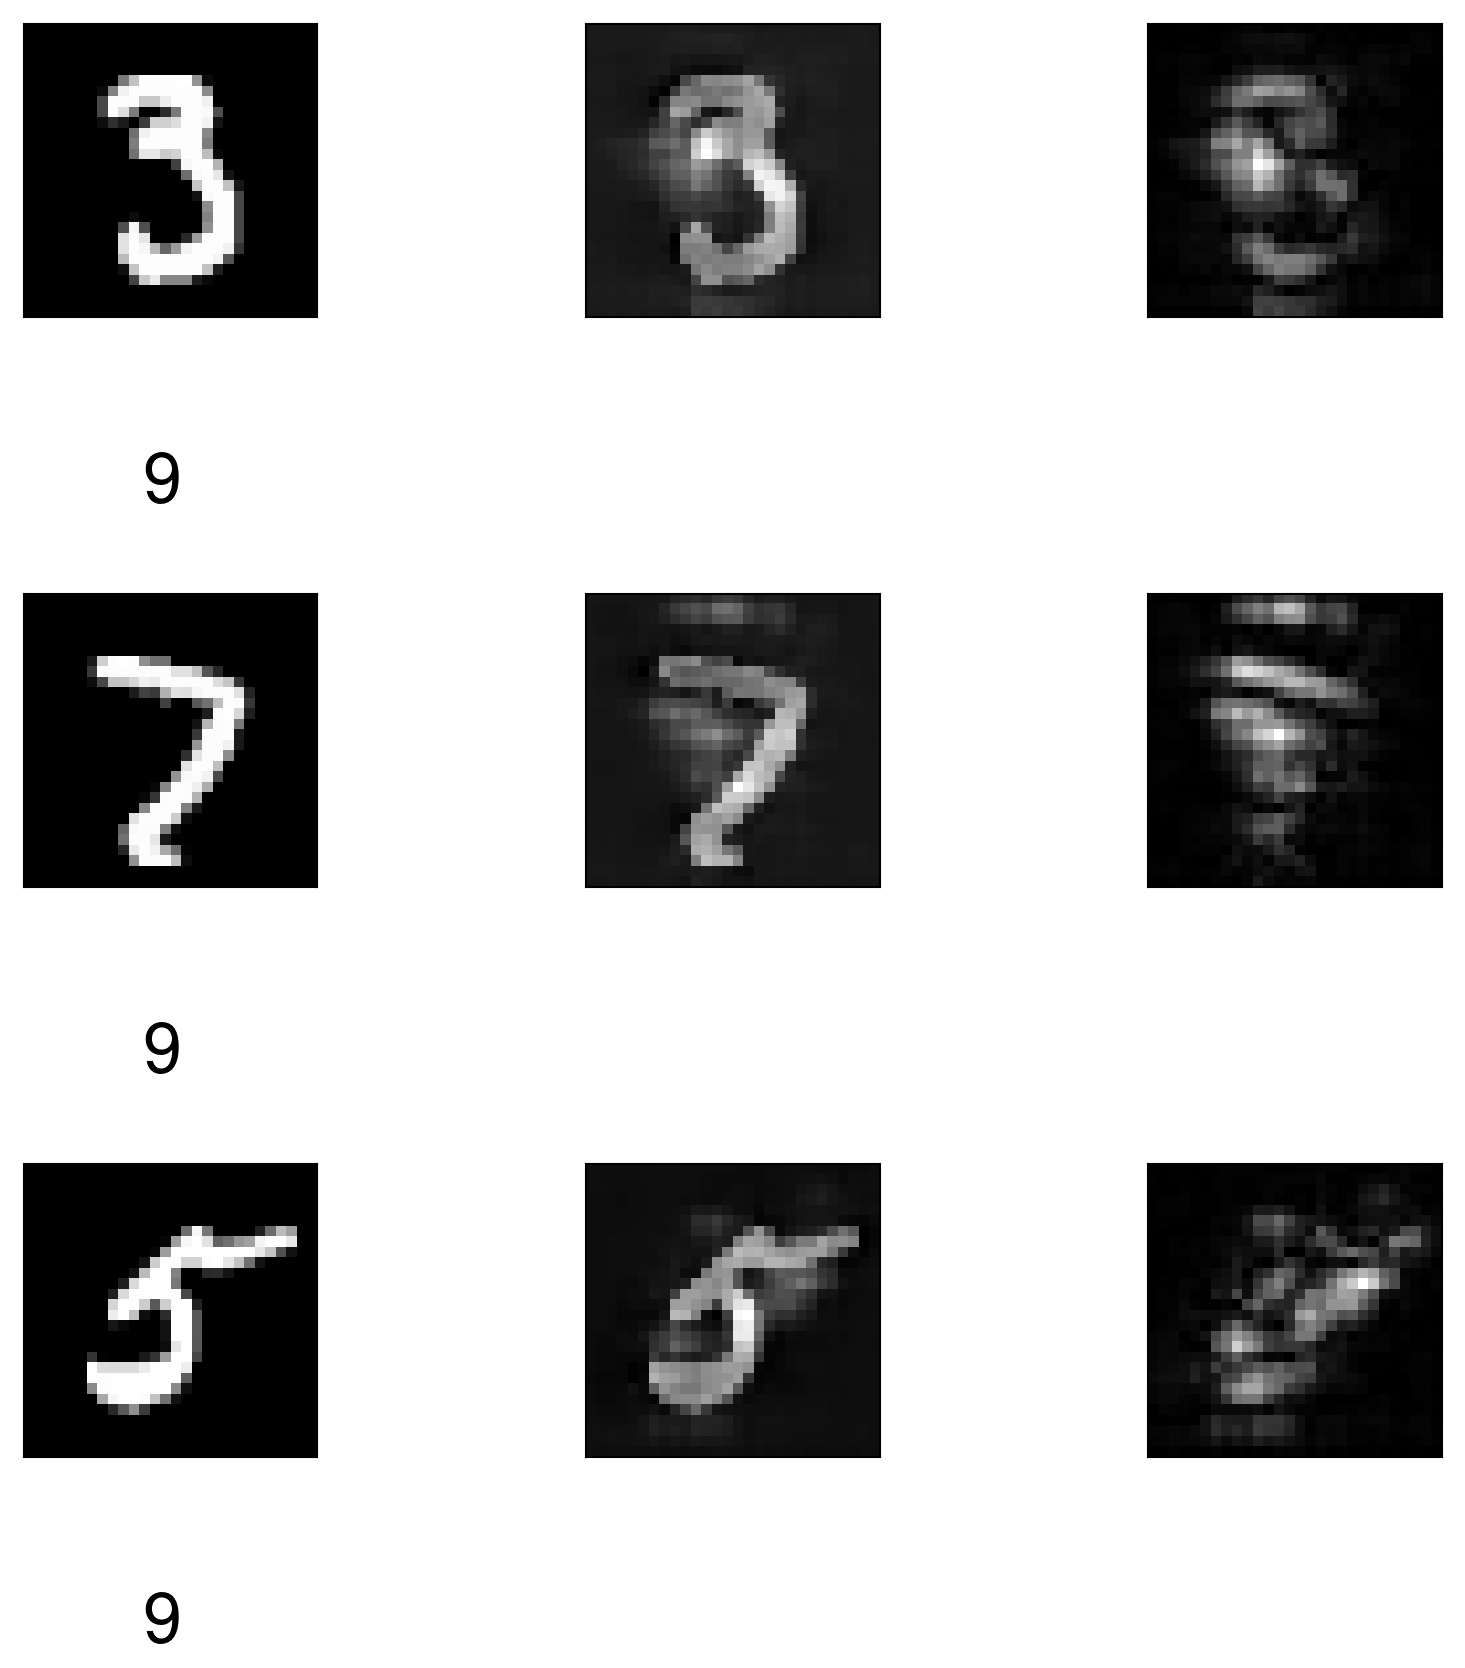

In [ ]:
def generate_plot_generated_images(gan, n_plots):
    for i_batch, batch in enumerate(test_loader):
        input, _ = batch
        input = input[:n_plots]

        with torch.no_grad():
            gen_output = gan.generator(input.to(device)).cpu()

        abs_diff = torch.abs(input - gen_output)
        break

    fig, axs = plt.subplots(n_plots, 3, figsize=((3, n_plots)))

    for i_row, row_axs in enumerate(axs):
        row_axs[0].imshow(tensor_to_image(input[i_row]), cmap="gray")
        row_axs[0].set_xlabel(r"$\downarrow$\\9")
        row_axs[1].imshow(tensor_to_image(gen_output[i_row]), cmap="gray")
        row_axs[2].imshow(tensor_to_image(abs_diff[i_row]), cmap="gray")

        [(ax.set_xticks([]), ax.set_yticks([])) for ax in row_axs]

    fig.show()


# gan = GAN(
#     generator=generator_model.create(),
#     discriminator_1=discriminator_1.create()
# ).to(device)
# gan.load_state_dict(torch.load(EXPERIMENT_1_DIR / "gan_experiment_discriminator_1_1_50.0.pth"))
plot = generate_plot_generated_images(gan, 3)
# plot.show()

In [ ]:
torch.save(gan.state_dict(),  "nice_gan_full.pth")

In [ ]:
gan.load_state_dict(torch.load("/content/drive/MyDrive/data/results/nice_gan_full.pth"))
gan.to(device)

GAN(
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (generator): Generator(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
      (postprocess): Identity()
    )
    (bottleneck): ConvolutionalNeuralNetwork(
  

In [ ]:
def compute_confusion_matrix(generate_image=False):
    # Initialize lists to store predictions and ground truth labels
    predicted_labels = []
    ground_truth_labels = []

    # Iterate through the test loader
    for batch in test_loader:
        images, labels = batch

        if generate_image:
            # Pass the images through the generator to generate fake images
            generated_images = gan.generator(images.to(device)).cpu()
        else:
            generated_images = images

        # Pass generated images through discriminator 2 to get predictions
        disc_2_output_fake = F.softmax(gan.discriminator_2(generated_images.to(device)).cpu(), dim=1)
        batch_predicted_labels = torch.argmax(disc_2_output_fake, dim=1)

        # Append batch predictions and ground truth labels to the lists
        predicted_labels.extend(batch_predicted_labels.tolist())
        ground_truth_labels.extend(labels.tolist())

    # Convert lists to numpy arrays
    predicted_labels = np.array(predicted_labels)
    ground_truth_labels = np.array(ground_truth_labels).flatten()

    conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels, normalize="true")*100
    class_labels = sorted(set(ground_truth_labels))

    return conf_matrix, class_labels

conf_matrix, class_labels = compute_confusion_matrix(generate_image=False)
conf_matrix_gen, class_labels_gen = compute_confusion_matrix(generate_image=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


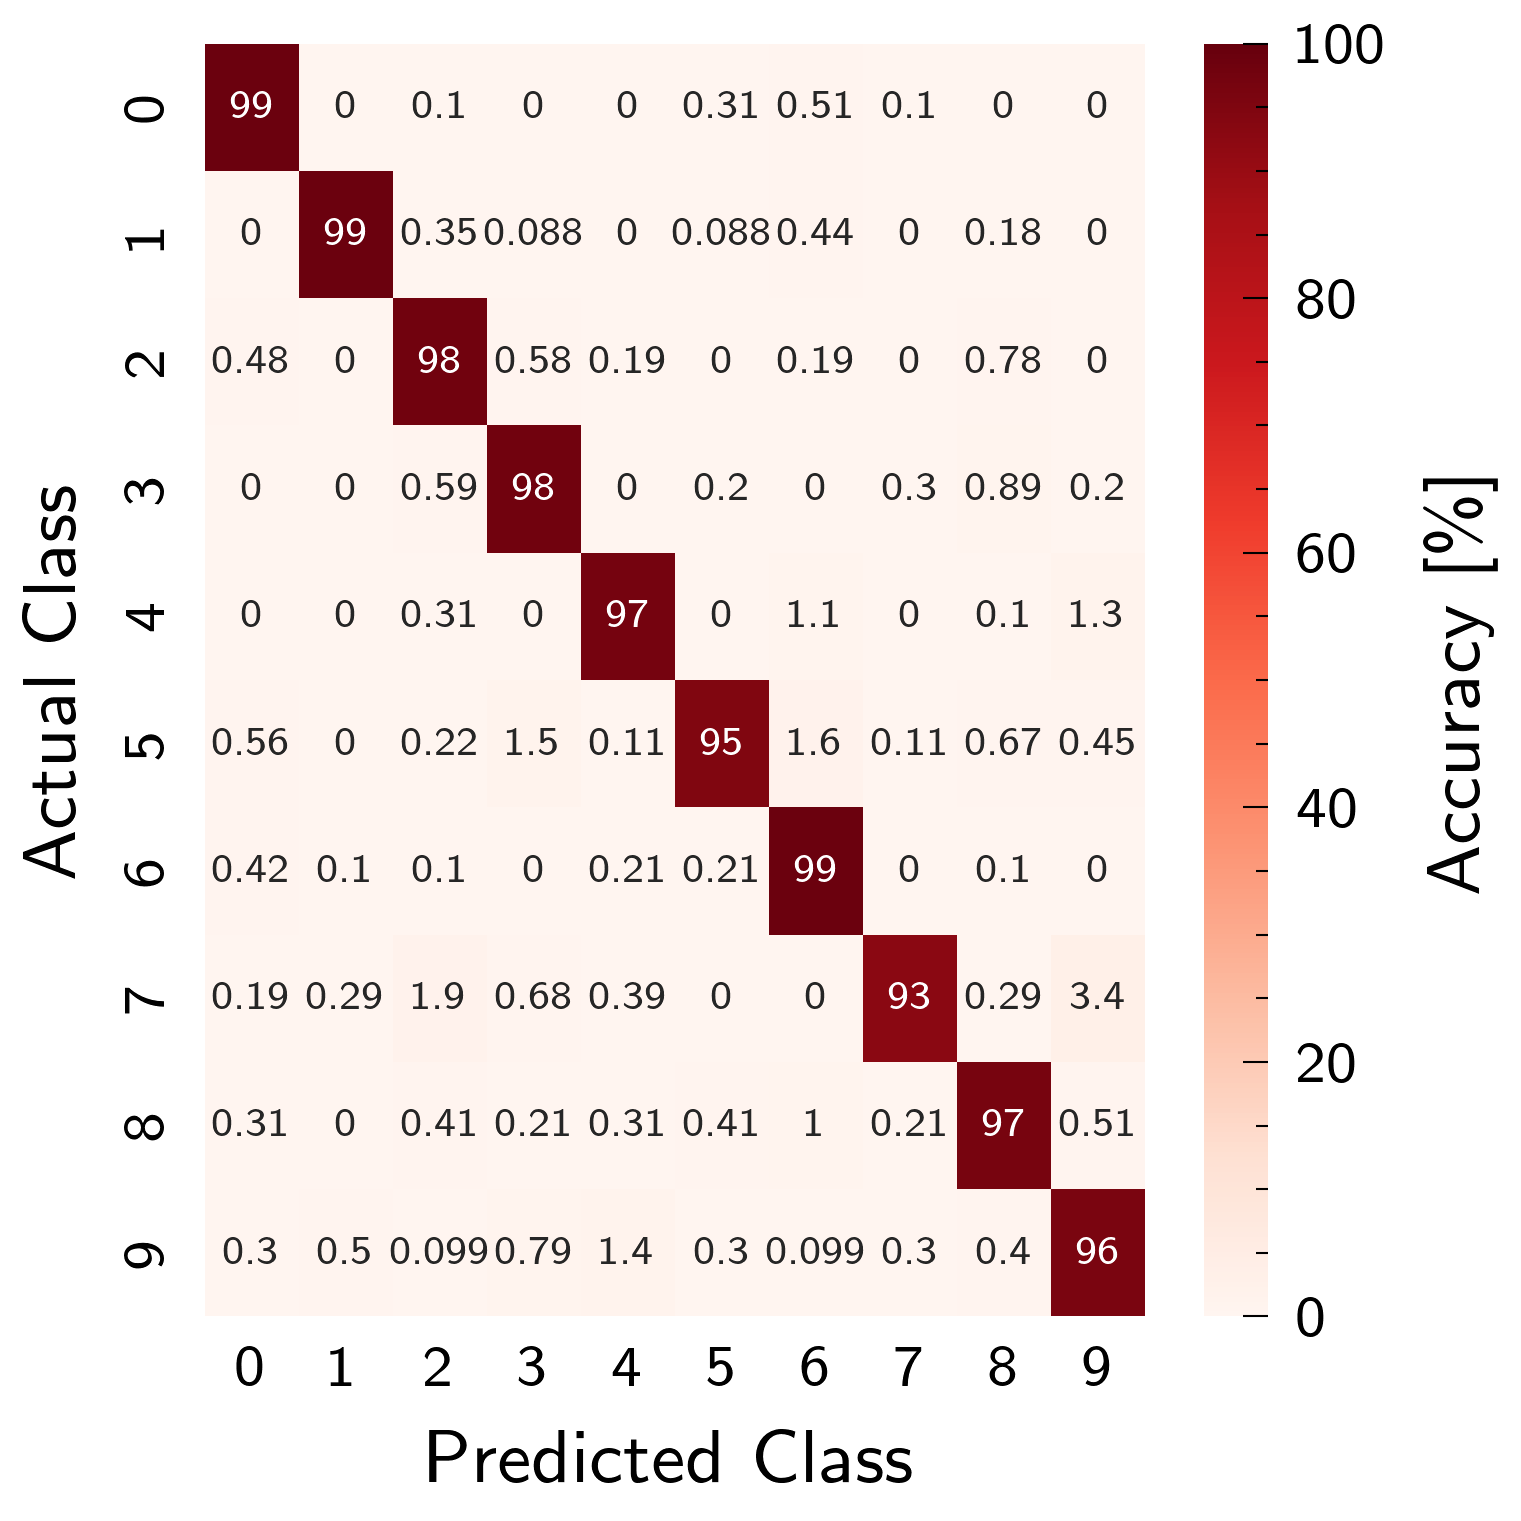

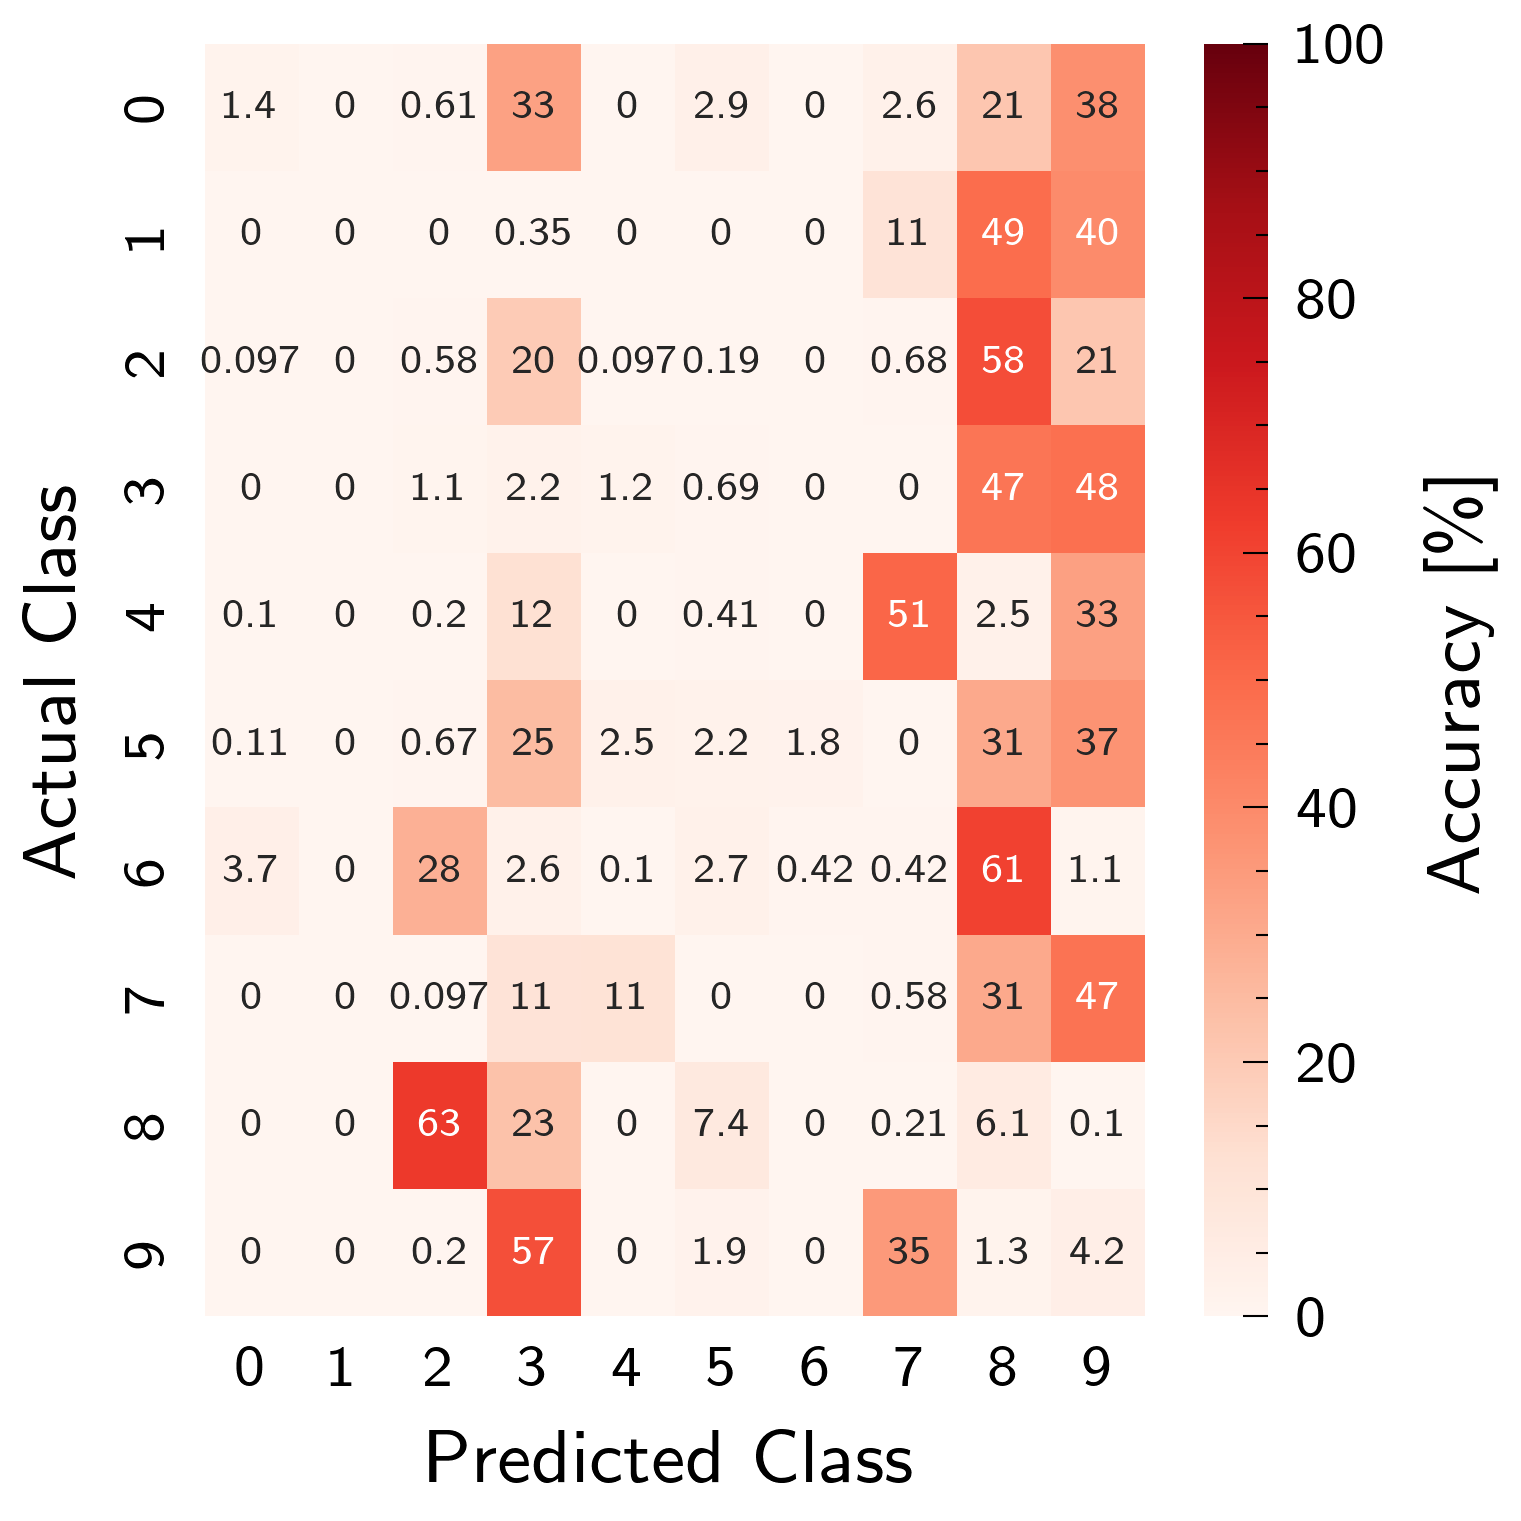

In [ ]:
def plot_confusion_matrix(conf_matrix, class_labels, plot_name):
    # Plot confusion matrix using seaborn's heatmap
    cm = 1/2.54  # centimeters in inches
    plt.figure(figsize=(7*cm, 7*cm))
    # Remove cbar ticks (using cbar_kwargs)
    sns.heatmap(conf_matrix, annot=True, annot_kws=dict(fontsize=5), fmt=".2g",cmap="Reds", xticklabels=class_labels, yticklabels=class_labels, vmin=0, vmax=100, cbar_kws=dict(label="Accuracy $[\%]$"))
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    plt.tick_params(which="both",width=0)
    plt.savefig(f"plot_{plot_name}.png")

plot_confusion_matrix(conf_matrix, class_labels,"confusion_matrix_mnist")
plot_confusion_matrix(conf_matrix_gen, class_labels_gen,"confusion_matrix_generated_mnist")


In [ ]:
def generate_gaussian_noise(input_images, alpha):
    # Generate random Gaussian noise with the same size as the input image
    mean=0
    std=0.1
    noise = torch.randn_like(input_images) * std + mean
    scaled_alpha = alpha / torch.norm(noise, dim = (2,3))
    scaler = torch.ones_like(input_images) * scaled_alpha.unsqueeze(1).unsqueeze(2)
    noise = noise * scaler* 3  #added factor of 3 to increase noise.

    noisy_images = input_images + noise

    # Clip the pixel values to ensure they're within the valid range [0, 1]
    noisy_images = torch.clamp(noisy_images, 0, 1)

    return noisy_images

def generate_images(input_images):
    with torch.no_grad():
        gen_output = gan.generator(input_images.to(device)).cpu()

    return gen_output


def classify_images(images):
    # Test discriminator 2 accuracy on images with gaussian noise
    with torch.no_grad():
        discriminator_2_output = gan.discriminator_2(images.to(device)).cpu()

    return discriminator_2_output


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Discriminator 2 guess on input images (real)
 tensor([3, 0, 0, 0, 5])

Discriminator 2 guess on generated images (fake)
 tensor([[8, 9, 8, 3, 9]])

Discriminator 2 guess on noisy images (fake)
 tensor([[3, 0, 0, 0, 5]])

Input images accuracy
 tensor(0.9698)

Generated images accuracy
 tensor(0.0173)

Noisy images accuracy
 tensor(0.7985)

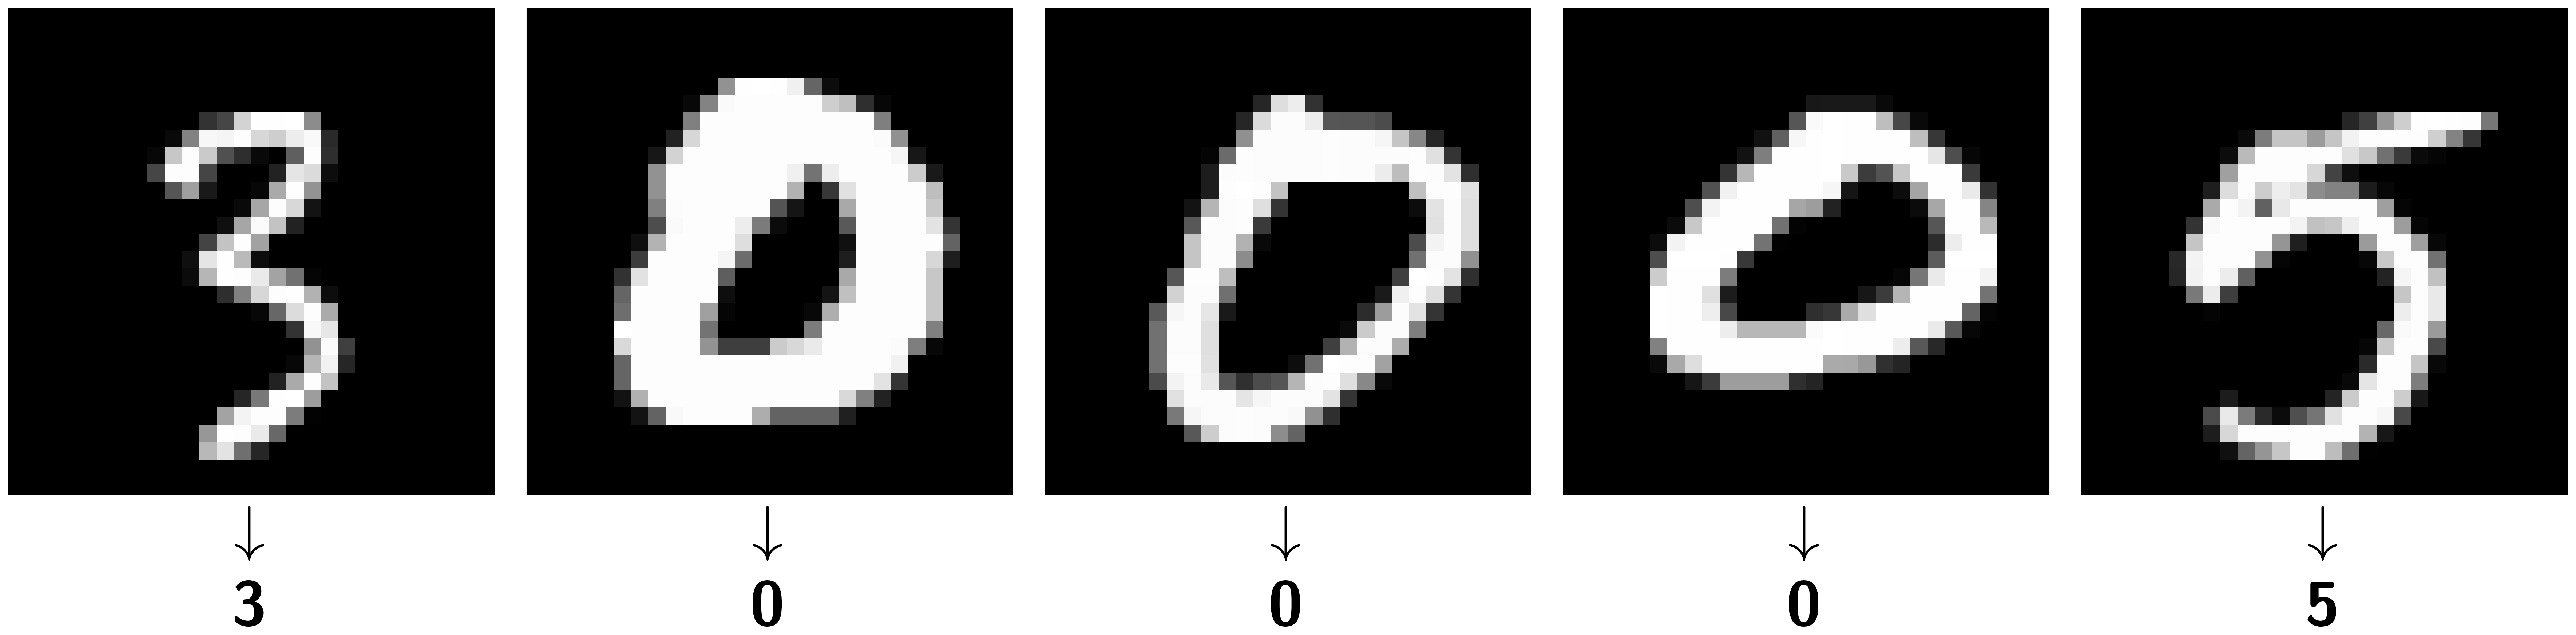

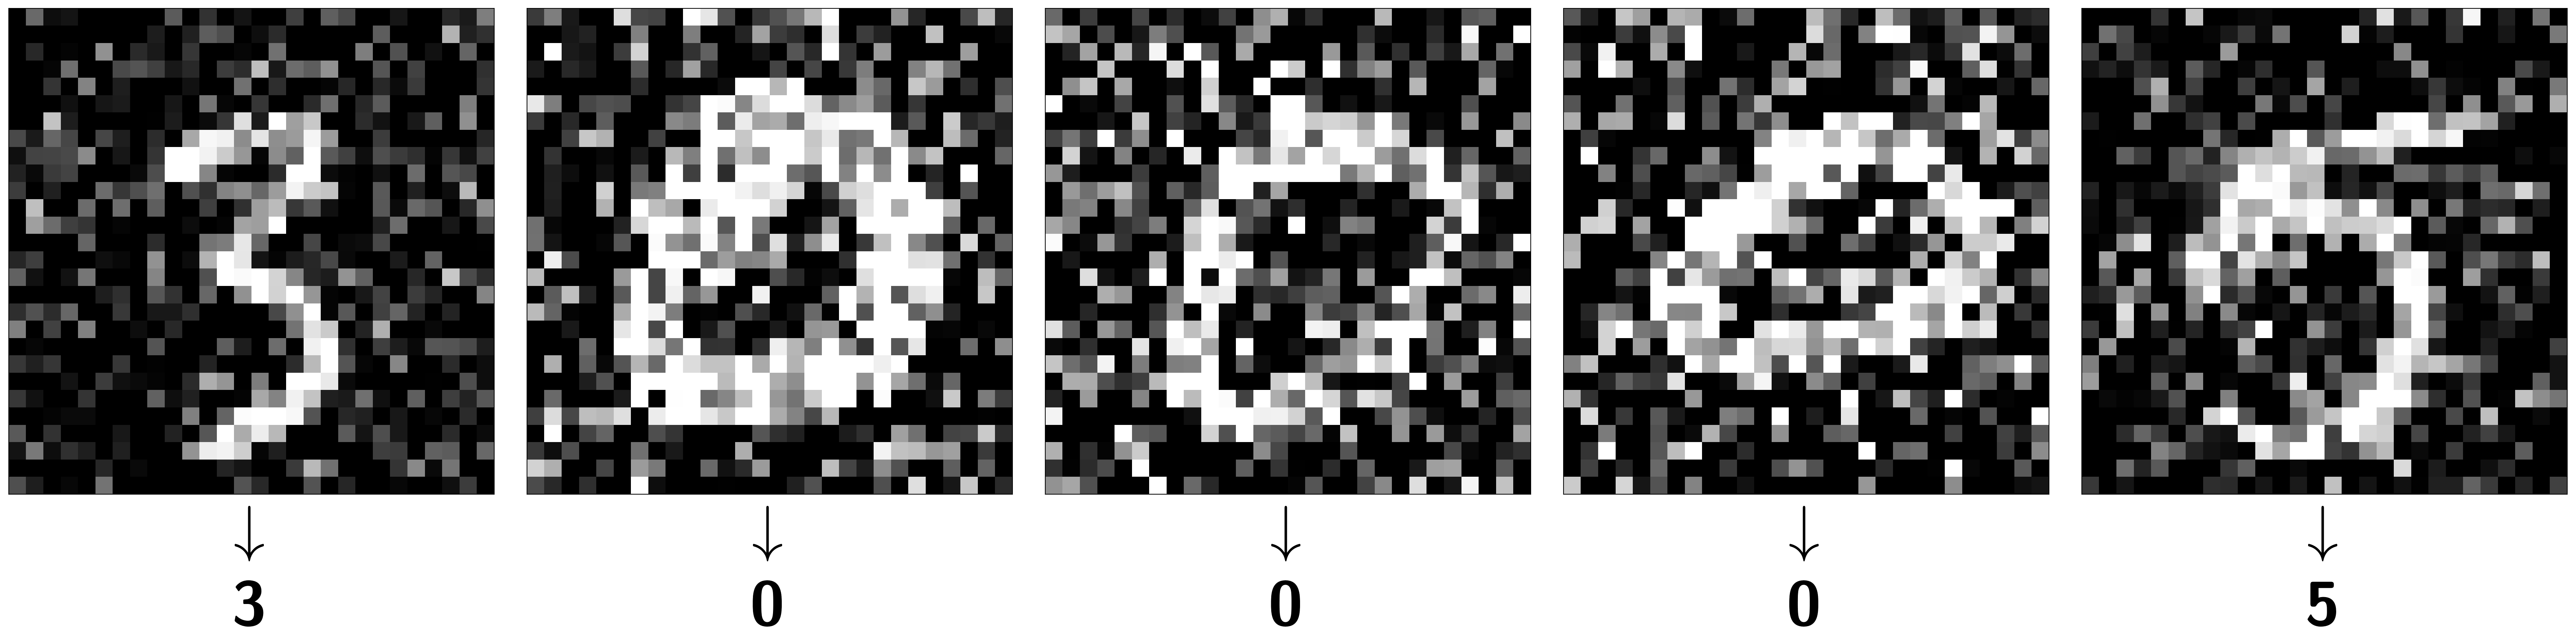

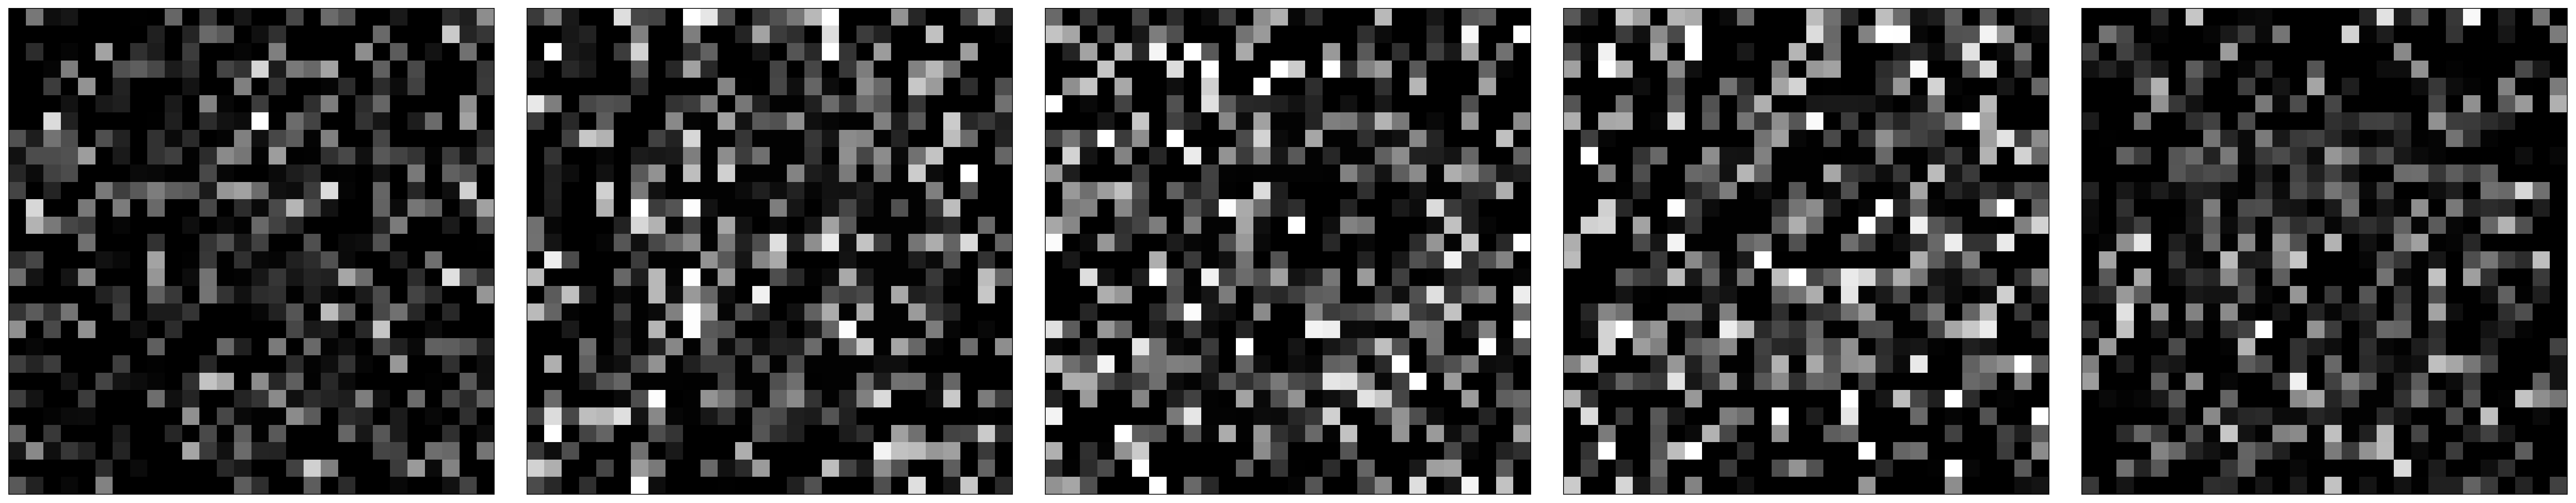

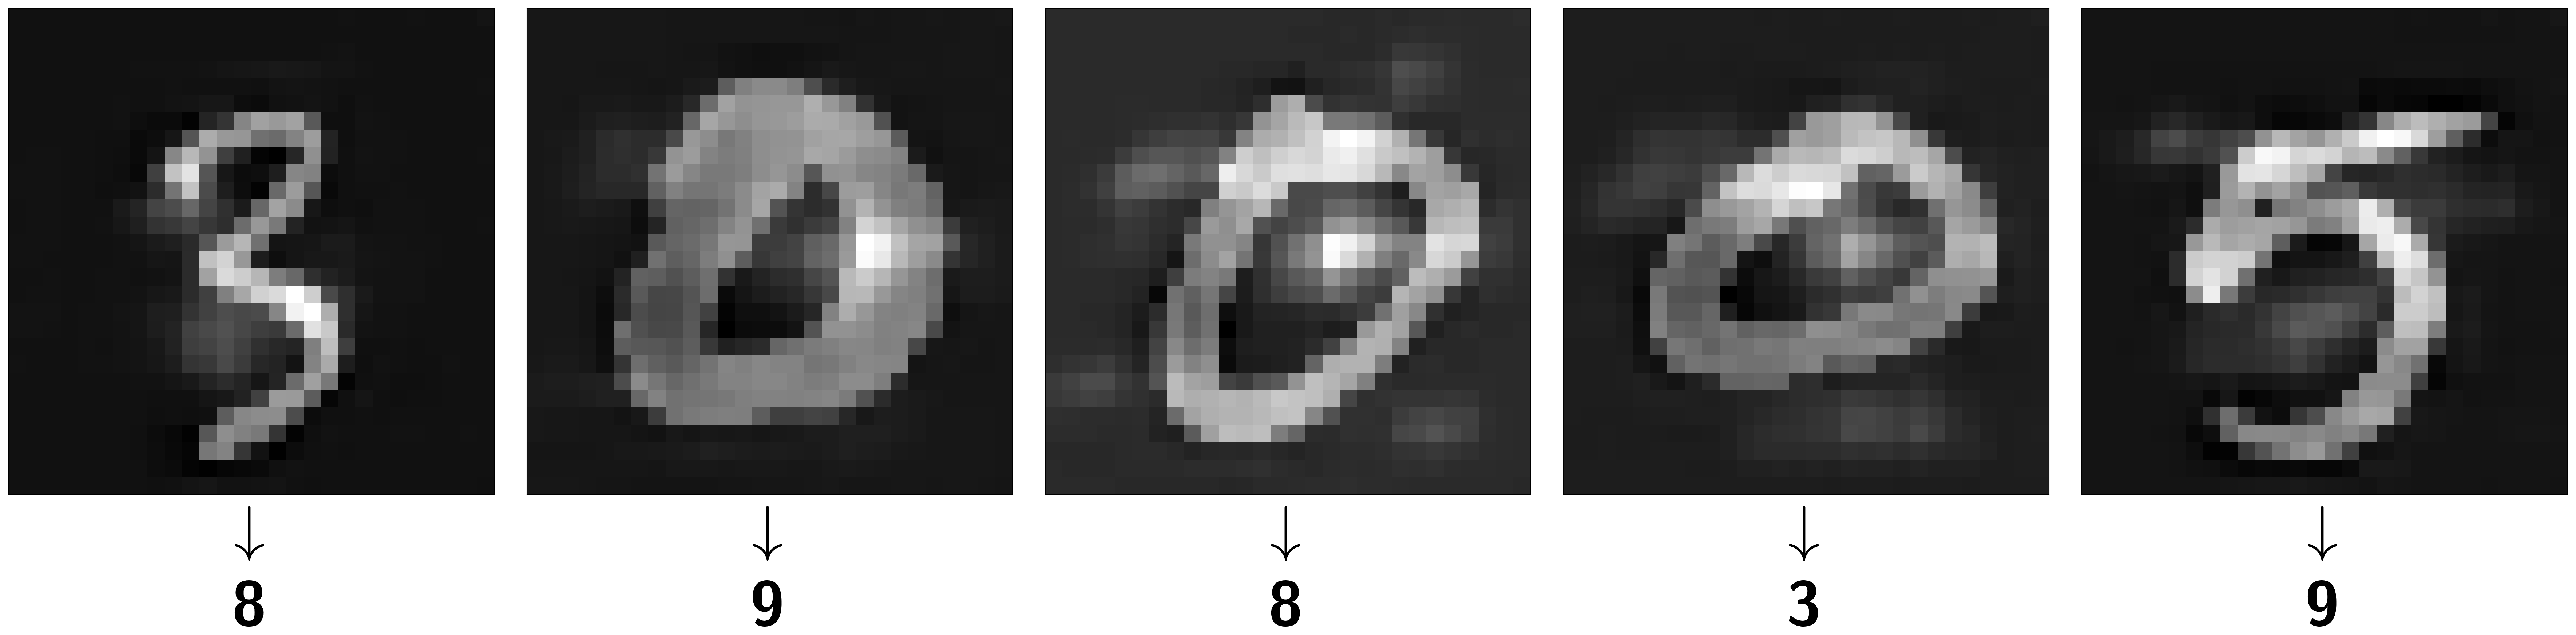

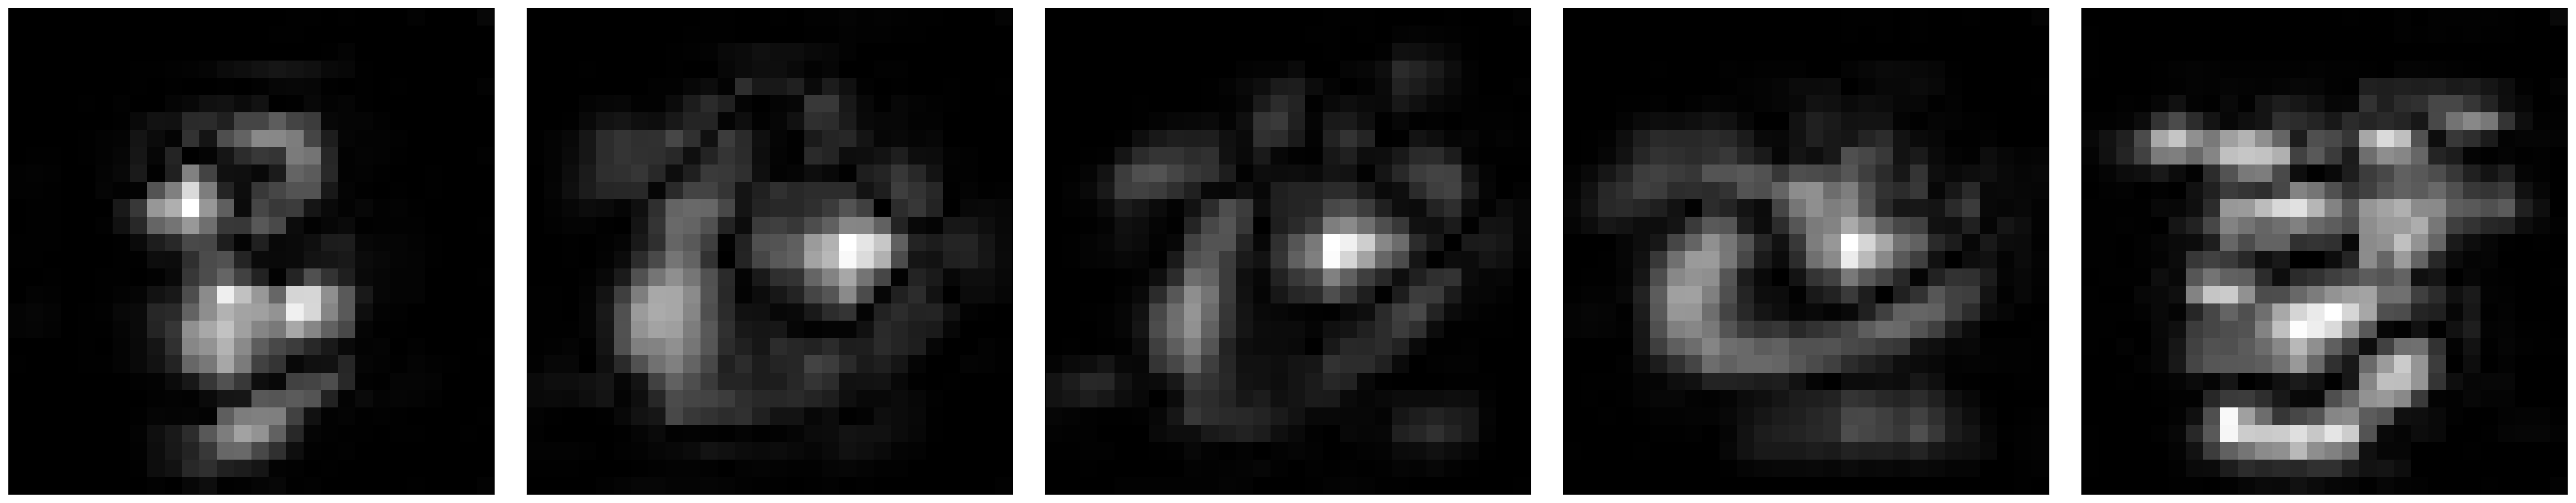

In [ ]:
#IMPLEMENT
def other_classify_images(images):
  # Test Other discriminator accuracy on images with gaussian noise
  other_discriminator = gan.other_discriminator
  with torch.no_grad():
    other_discriminator_output = other_discriminator(images)
  return other_discriminator_output


def plot_images(batch_tensor, n_plots, plot_name, classifications=None, name=None):
    fig, axs = plt.subplots(1, n_plots, figsize=((6*2, n_plots * 6)))

    for i_ax, ax, img in zip(range(n_plots), axs.ravel(), [tensor_to_image(o) for o in batch_tensor[:n_plots].clone().detach()]):
        ax.imshow(img.squeeze(), cmap="gray")

        if name and i_ax == 0:
            ax.set_ylabel(name)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # else:
        #     ax.set_axis_off()

        if classifications is not None:
            ax.set_xlabel(r"\huge$\downarrow$\\\vspace{2mm}\textbf{" + str(classifications[i_ax].item()) + "}")

    plt.savefig(f"plot_{plot_name}.png")


input_images_matches = 0
generated_images_matches = 0
noisy_images_matches = 0

for i_batch, batch in enumerate(test_loader):
    input_images = batch[0]
    gen_images = generate_images(input_images)
    labels = batch[1].squeeze()

    gen_diff = input_images - gen_images
    gen_norm = torch.norm(gen_diff, dim=(2,3))
    alpha = gen_norm

    noisy_images = generate_gaussian_noise(input_images, alpha = alpha)
    gaussian_diff = input_images - noisy_images
    gaussian_norm = torch.norm(gaussian_diff, dim=(2,3))

    classified_input_images = torch.argmax(classify_images(input_images),dim=1)
    classified_generated_images = torch.argmax(classify_images(gen_images),dim=1)
    classified_noisy_images = torch.argmax(classify_images(noisy_images),dim=1)

    input_images_matches += torch.sum(labels == classified_input_images)
    generated_images_matches += torch.sum(labels == classified_generated_images.unsqueeze(-1).transpose(0,1))
    noisy_images_matches += torch.sum(labels == classified_noisy_images.unsqueeze(-1).transpose(0,1))


    # print('gen norm', gen_norm[:5])
    # print('gaussian', gaussian_norm[:5])
    if i_batch == 0:
      # Visualize the first few images
      n_plots = 5
      plot_images(input_images, n_plots, "mnist_input", classified_input_images)
      plot_images(noisy_images, n_plots, "mnist_noisy", classified_noisy_images)
      plot_images(torch.abs(gaussian_diff), n_plots, "mnist_gaussian_diff")
      plot_images(gen_images, n_plots, "mnist_generated", classified_generated_images)
      plot_images(torch.abs(gen_diff), n_plots, "mnist_generated_diff")

      print("Discriminator 2 guess on input images (real)\n", classified_input_images[:5])
      print("Discriminator 2 guess on generated images (fake)\n", classified_generated_images[:5].unsqueeze(-1).transpose(0,1))
      print("Discriminator 2 guess on noisy images (fake)\n", classified_noisy_images[:5].unsqueeze(-1).transpose(0,1))


    #break  # Remove this line to process the entire dataset


print("Input images accuracy\n", input_images_matches / len(test_loader.dataset)) #/input_images.size(0))
print("Generated images accuracy\n", generated_images_matches / len(test_loader.dataset)) #/input_images.size(0))
print("Noisy images accuracy\n", noisy_images_matches / len(test_loader.dataset)) #/input_images.size(0))



In [ ]:
def generate_ssims(gan, strength_factor=1):
    gen_image_ssims = []
    noisy_image_ssims = []
    ssim = StructuralSimilarityIndexMeasure(reduction=None)

    for i_batch, batch in enumerate(test_loader):
        input, _ = batch

        with torch.no_grad():
            gen_output = gan.generator(input.to(device)).cpu()

        gen_diff = input - gen_output
        gen_norm = torch.norm(gen_diff, dim=(2,3))

        noisy_input = generate_gaussian_noise(input, alpha = gen_norm)
        gaussian_diff = input_images - noisy_images

        gen_image_ssims.append(ssim(gen_output, input))
        noisy_image_ssims.append(ssim(noisy_input, input))

    gen_image_ssims = torch.concat(gen_image_ssims)
    noisy_image_ssims = torch.concat(noisy_image_ssims)

    return gen_image_ssims, noisy_image_ssims

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.7590298056602478 0.5270724892616272

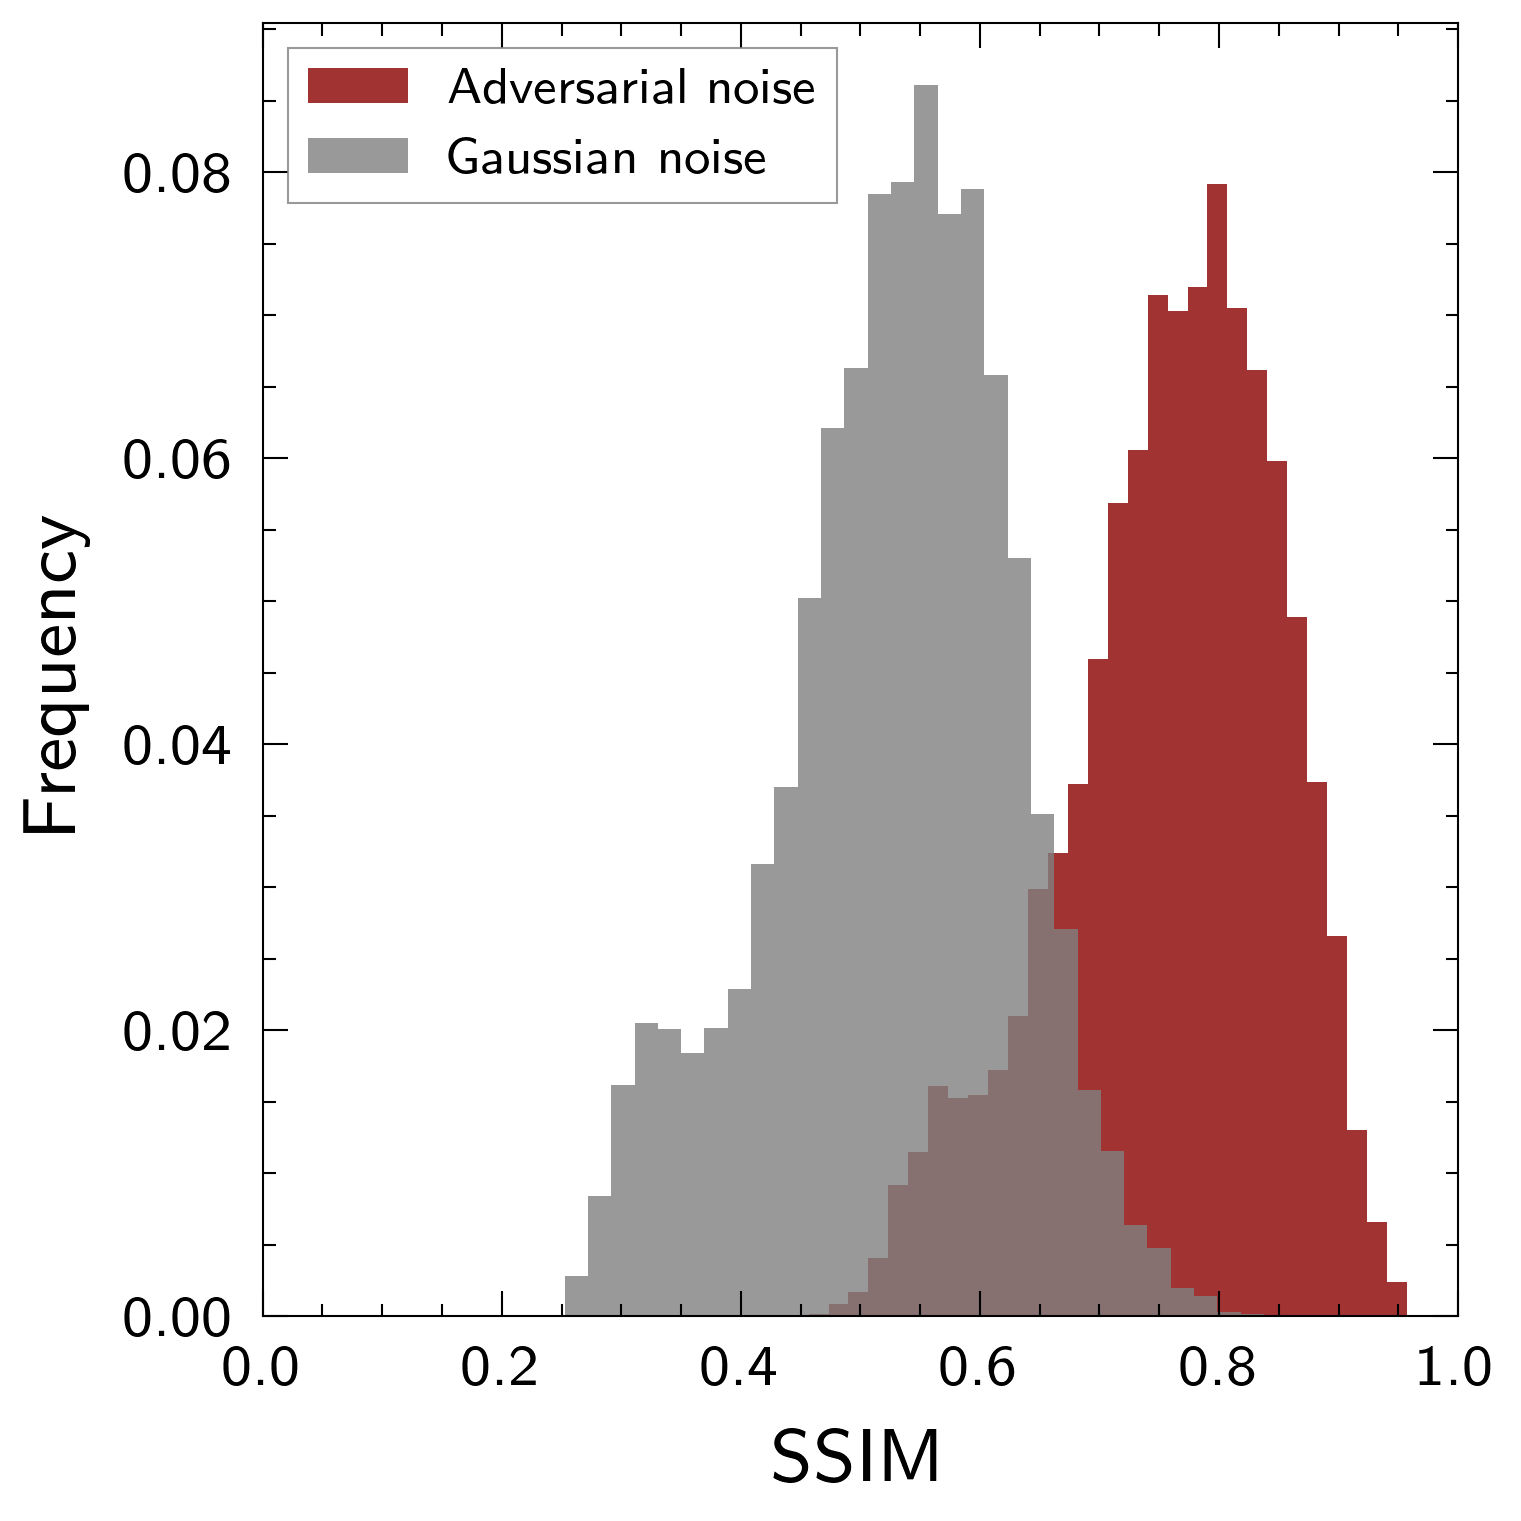

In [ ]:
def plot_ssim_histograms(gen_image_ssims, noisy_image_ssims, plot_name):
    # plt.figure(figsize=(5,2))
    cm = 1/2.54  # centimeters in inches
    plt.figure(figsize=(7*cm, 7*cm))
    sns.histplot(gen_image_ssims.detach().cpu().numpy(), stat="probability", bins=30, color="darkred", edgecolor=None, alpha=0.8, label="Adversarial noise")
    sns.histplot(noisy_image_ssims.detach().cpu().numpy(), stat="probability", bins=30, color="gray", edgecolor=None, alpha=0.8, label="Gaussian noise")
    plt.xlim(0,1)
    plt.xlabel("SSIM")
    plt.ylabel("Frequency")
    plt.legend()
    plt.savefig(f"plot_{plot_name}.png")

gen_image_ssims, noisy_image_ssims = generate_ssims(gan)
print(torch.mean(gen_image_ssims).item(), torch.mean(noisy_image_ssims).item())
plot_ssim_histograms(gen_image_ssims, noisy_image_ssims, "test_ssim_histogram_adversarial_gaussian")

In [ ]:
import pandas as pd

In [ ]:
def calc_accuracy_over_strength_factor(gan, n_steps=11):
    strength_factors = np.linspace(0, 1, n_steps).tolist()
    gen_image_accuracy_results = []
    noisy_image_accuracy_results = []
    gen_image_ssim_results = []
    noisy_image_ssim_results = []

    for factor in strength_factors:
        input_matches = 0
        n_gen_output_matches = 0
        n_noisy_input_matches = 0
        gen_image_ssims = []
        noisy_image_ssims = []
        ssim = StructuralSimilarityIndexMeasure(reduction=None)

        for i_batch, batch in enumerate(test_loader):
            input, labels = batch
            factor_tensor = torch.ones_like(input) * factor

            with torch.no_grad():
                gen_output = gan.generator(input.to(device)).cpu()

            gen_diff = gen_output - input
            gen_norm = torch.norm(gen_diff, dim=(2, 3))

            noisy_input = generate_gaussian_noise(input, alpha=gen_norm)
            noisy_diff = noisy_input - input

            # Add noise to input images up to a factor
            gen_output_factorized = input + factor_tensor * gen_diff
            noisy_input_factorized = input + factor_tensor * noisy_diff

            gen_image_ssims.append(ssim(gen_output_factorized, input))
            noisy_image_ssims.append(ssim(noisy_input_factorized, input))

            with torch.no_grad():
                classified_gen_output = torch.argmax(gan.discriminator_2((gen_output_factorized).to(device)).cpu(), dim=1)
                classified_noisy_input = torch.argmax(gan.discriminator_2((noisy_input_factorized).to(device)).cpu(), dim=1)

            n_gen_output_matches += torch.sum(labels == classified_gen_output.unsqueeze(-1))
            n_noisy_input_matches += torch.sum(labels == classified_noisy_input.unsqueeze(-1))

        gen_image_accuracy_results.append((n_gen_output_matches / len(test_loader.dataset)).item())
        noisy_image_accuracy_results.append((n_noisy_input_matches / len(test_loader.dataset)).item())
        gen_image_ssim_results.append(torch.concat(gen_image_ssims).mean().item())
        noisy_image_ssim_results.append(torch.concat(noisy_image_ssims).mean().item())

    return pd.DataFrame(
        {
            "strength_factor": strength_factors,
            "gen_image_accuracy": gen_image_accuracy_results,
            "noisy_image_accuracy": noisy_image_accuracy_results,
            "gen_image_ssim": gen_image_ssim_results,
            "noisy_image_ssim": noisy_image_ssim_results,
        }
    )

accuracy_over_strength_factor_df = calc_accuracy_over_strength_factor(gan, 11)
accuracy_over_strength_factor_df.to_csv("accuracy_over_strength_factor.csv", sep=",")
accuracy_over_strength_factor_df

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,strength_factor,gen_image_accuracy,noisy_image_accuracy,gen_image_ssim,noisy_image_ssim
0,0.0,0.9698,0.9698,1.000000,1.000000
1,0.1,0.9675,0.9689,0.964830,0.893756
2,0.2,0.9609,0.9680,0.934315,0.827359
3,0.3,0.9472,0.9654,0.909603,0.783408
4,0.4,0.9139,0.9620,0.887427,0.745373
5,0.5,0.8442,0.9567,0.866225,0.708980
6,0.6,0.7007,0.9467,0.845530,0.672678
7,0.7,0.4333,0.9296,0.824536,0.636696
8,0.8,0.1767,0.9018,0.803101,0.599614
9,0.9,0.0493,0.8573,0.781290,0.563031


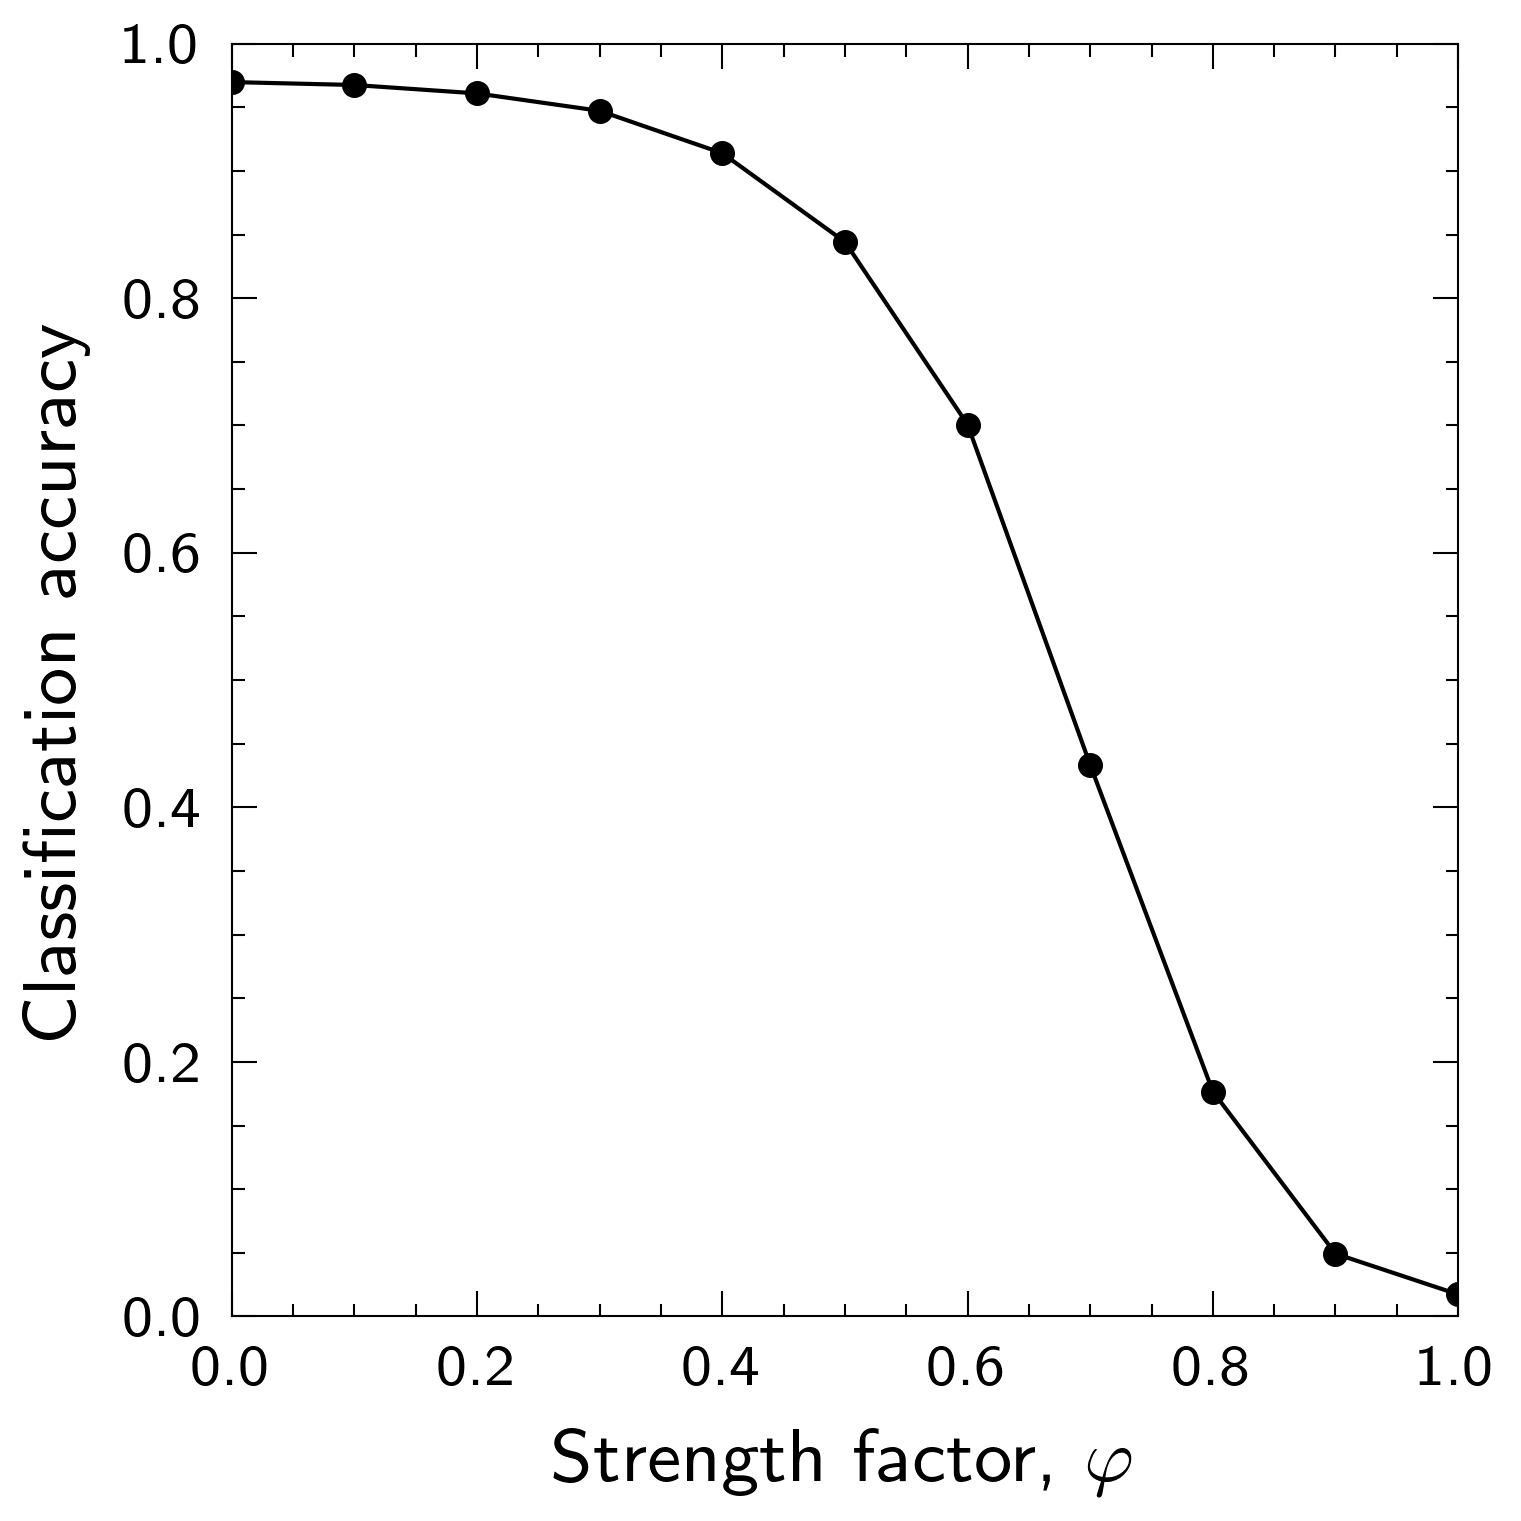

In [ ]:
def plot_accuracy_over_strength_factor(df):
    cm = 1/2.54  # centimeters in inches
    plt.figure(figsize=(7*cm, 7*cm))
    plt.plot(accuracy_over_strength_factor_df["strength_factor"], accuracy_over_strength_factor_df["gen_image_accuracy"], marker="o")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel(r"Strength factor, $\varphi$")
    plt.ylabel("Classification accuracy")
    plt.savefig(f"plot_accuracy_over_strength_factor.png")

plot_accuracy_over_strength_factor(accuracy_over_strength_factor_df)

In [ ]:
import pandas as pd

training_metrics_path = Path("/content/drive/MyDrive/data/results/gan_full_logs/version_0/metrics.csv")
training_metrics = pd.read_csv(training_metrics_path)

In [ ]:
training_metrics

,epoch,step,train_disc_1_loss_epoch,train_disc_1_loss_step,train_disc_2_loss_epoch,train_disc_2_loss_step,train_gen_loss_disc_1_epoch,train_gen_loss_disc_1_step,train_gen_loss_disc_2_epoch,train_gen_loss_disc_2_step,train_gen_loss_epoch,train_gen_loss_norm_epoch,train_gen_loss_norm_step,train_gen_loss_step
0,0,49,NaN,0.724621,NaN,2.301591,NaN,0.943305,NaN,1.001746,NaN,NaN,3.830167,5.775218
1,0,99,NaN,0.724541,NaN,2.299847,NaN,0.943633,NaN,1.001806,NaN,NaN,2.699704,4.645143
2,0,149,NaN,0.724442,NaN,2.276872,NaN,0.944595,NaN,1.041997,NaN,NaN,1.962386,3.948978
3,0,199,NaN,0.724269,NaN,2.156952,NaN,0.945820,NaN,1.342088,NaN,NaN,1.597957,3.885865
4,0,249,NaN,0.724090,NaN,2.041546,NaN,0.947316,NaN,1.777758,NaN,NaN,1.376779,4.101853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,16,15799,NaN,0.519518,NaN,1.502535,NaN,1.363211,NaN,0.798429,NaN,NaN,1.543019,3.704659
332,16,15849,NaN,0.522251,NaN,1.498179,NaN,1.354681,NaN,0.854841,NaN,NaN,1.403637,3.613160
333,16,15899,NaN,0.513674,NaN,1.504873,NaN,1.365476,NaN,0.835146,NaN,NaN,1.518979,3.719602
334,16,15945,0.517334,NaN,1.487588,NaN,1.362891,NaN,0.837263,NaN,3.818535,1.618379,NaN,NaN


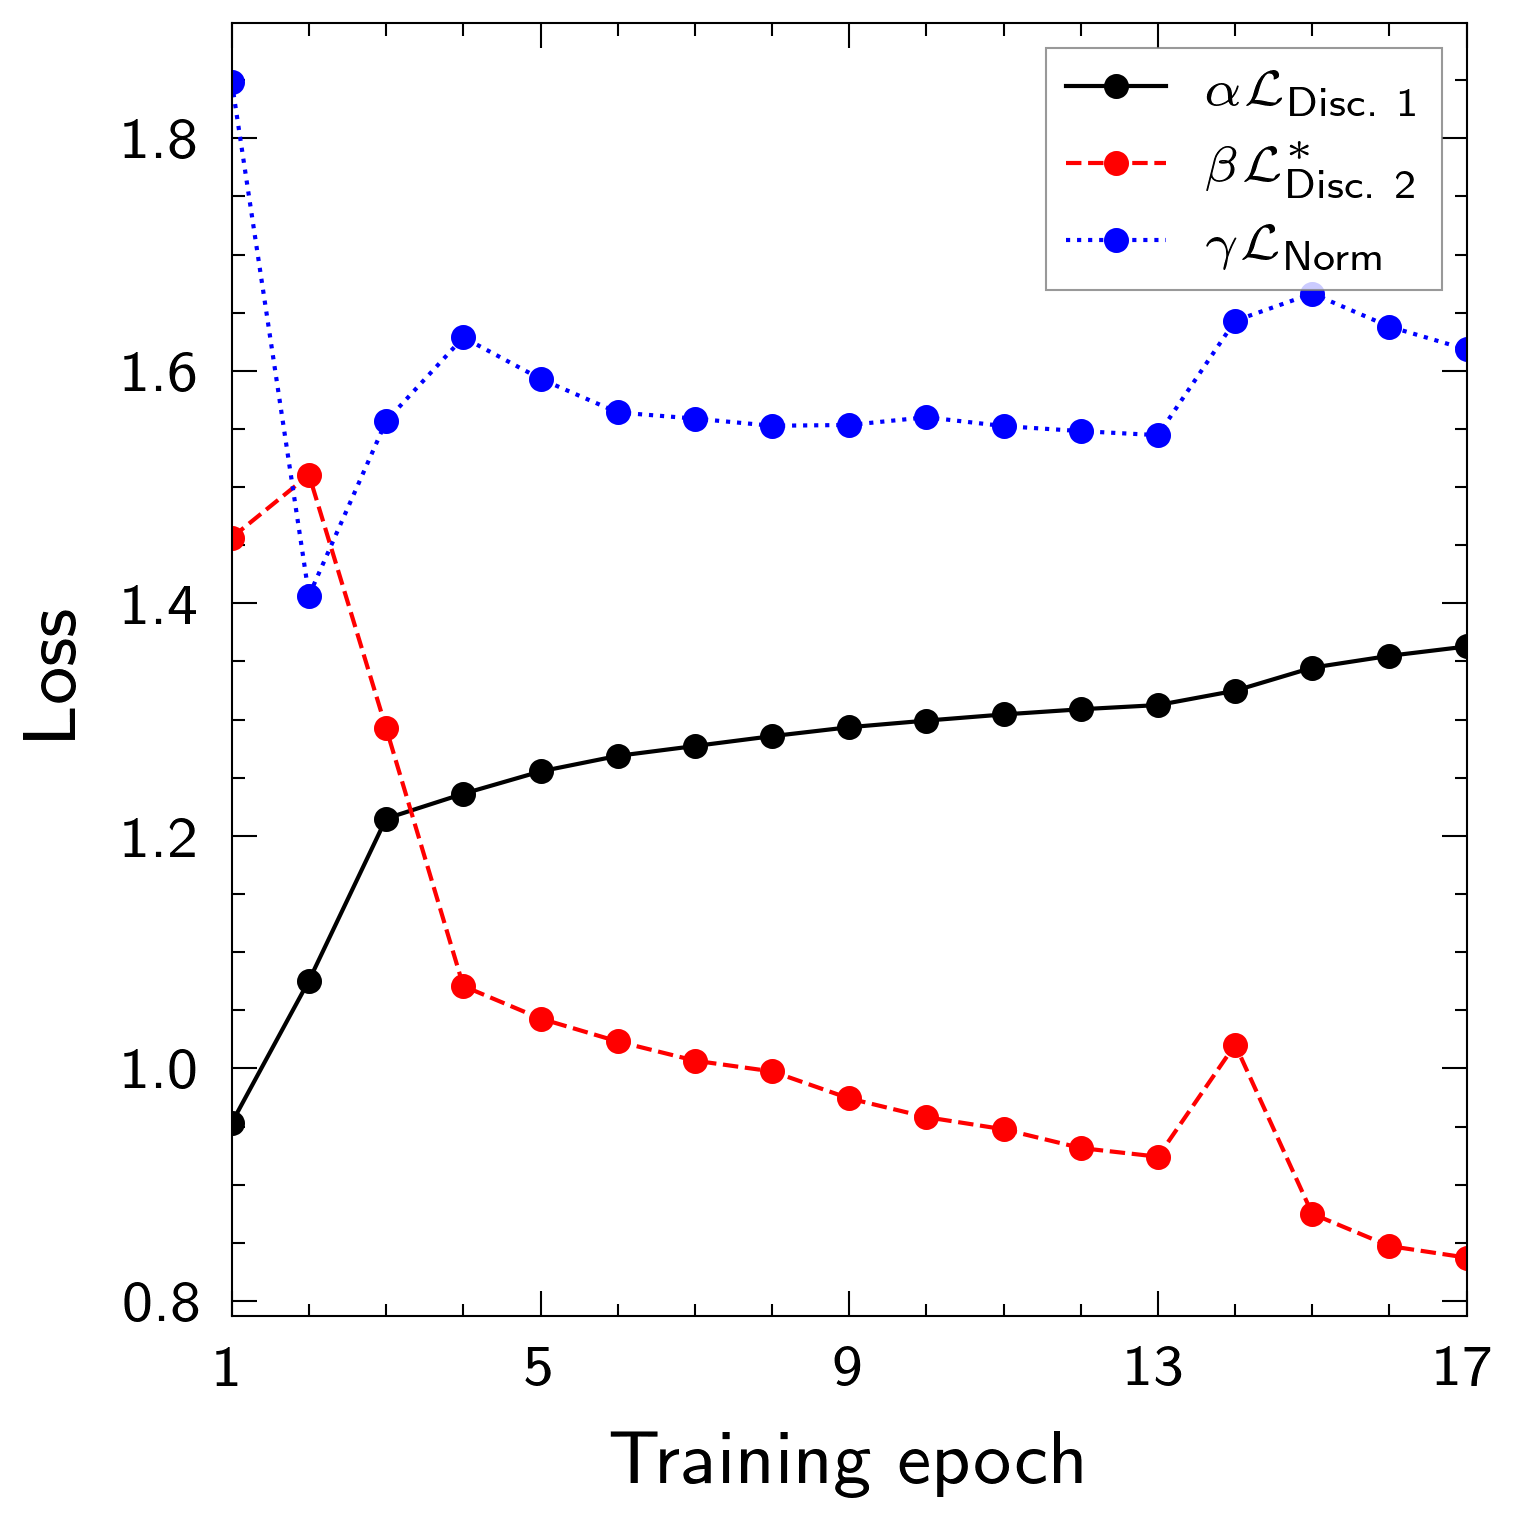

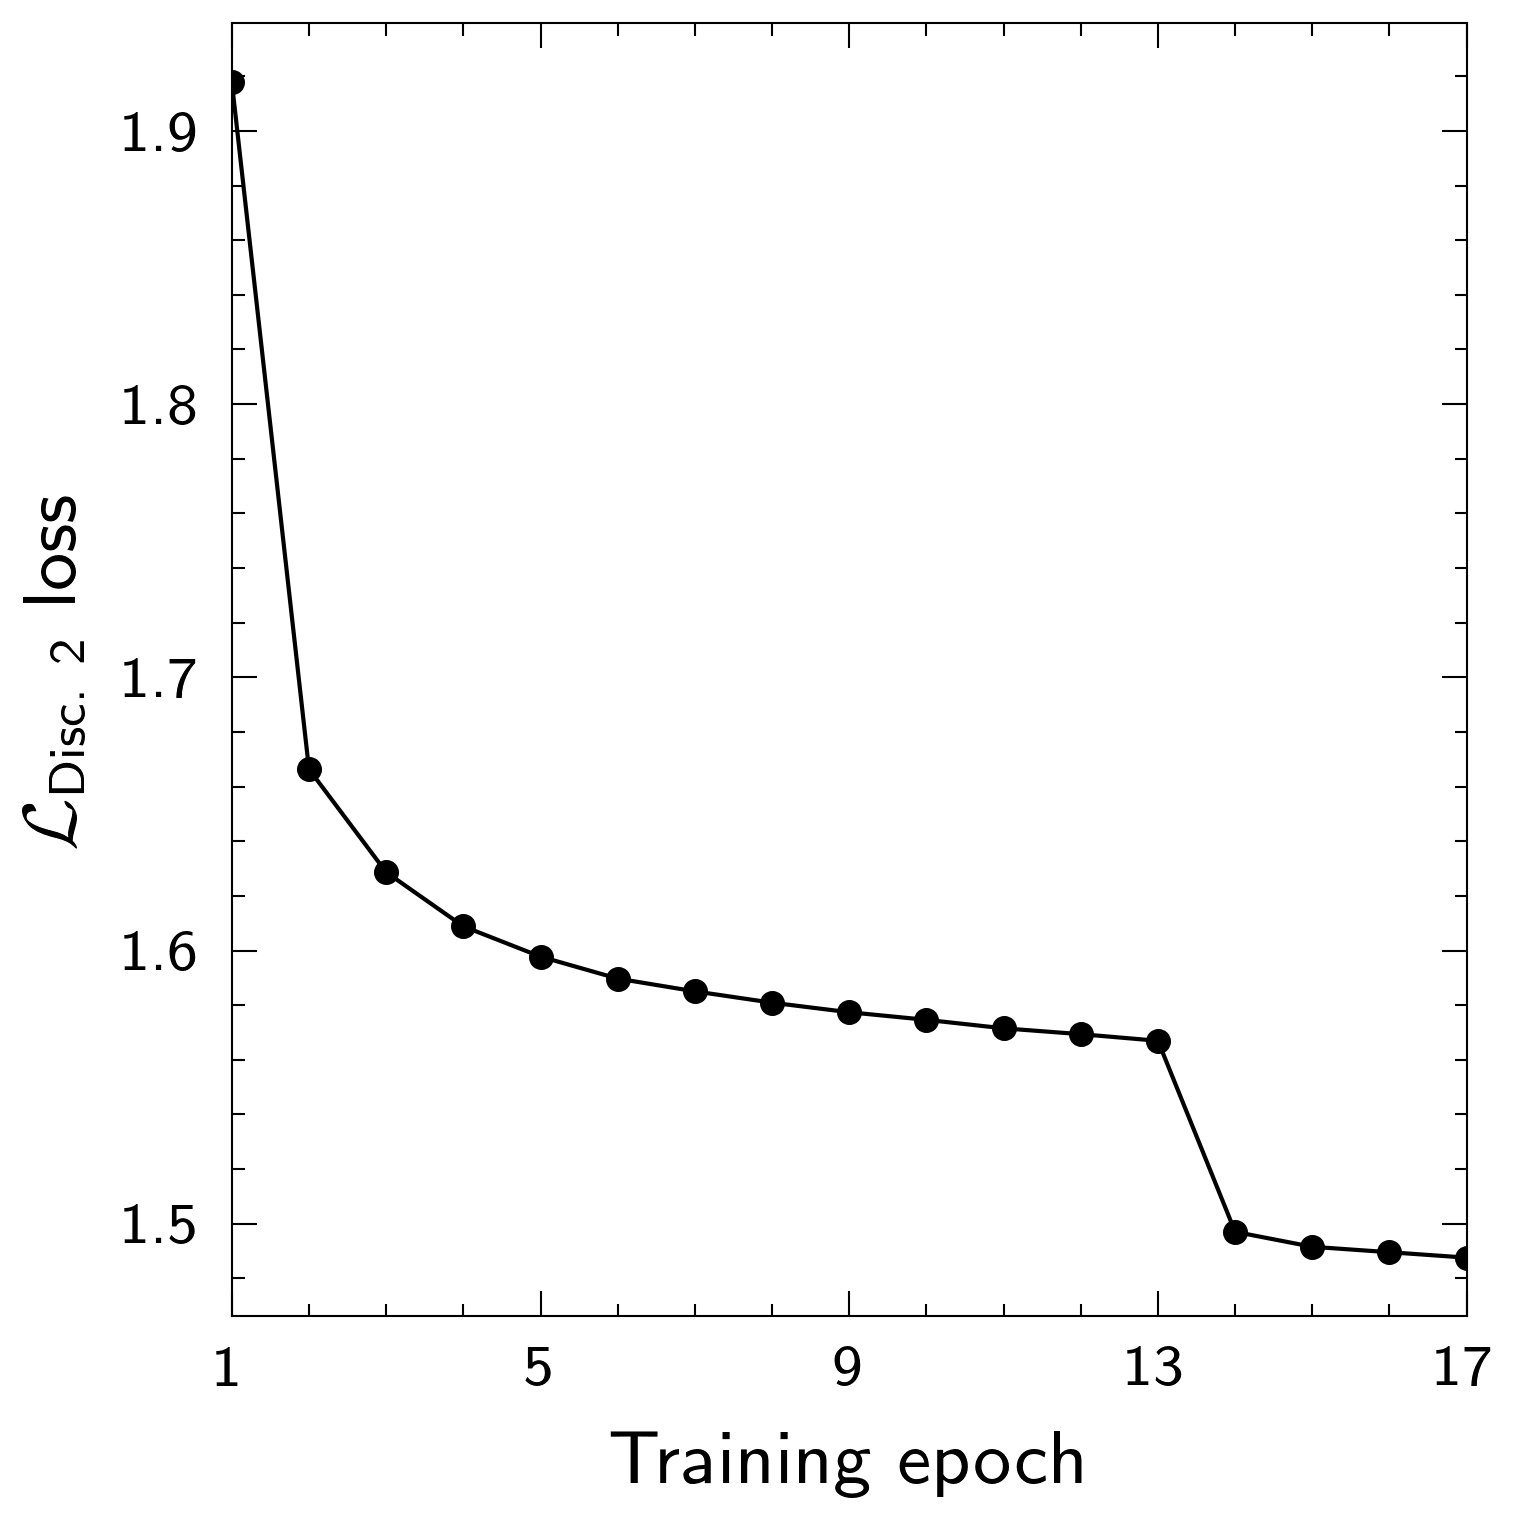

In [ ]:
def plot_metrics(metrics_df):

    # Plot generator losses
    cm = 1/2.54  # centimeters in inches
    plt.figure(figsize=(7*cm, 7*cm))

    plt.plot(metrics_df[metrics_df["train_gen_loss_disc_1_epoch"].notnull()]["epoch"]+1, metrics_df["train_gen_loss_disc_1_epoch"].dropna(), label=r"$\alpha \mathcal{L}_\text{Disc. 1}$", marker="o")
    plt.plot(metrics_df[metrics_df["train_gen_loss_disc_2_epoch"].notnull()]["epoch"]+1, metrics_df["train_gen_loss_disc_2_epoch"].dropna(), label=r"$\beta \mathcal{L}_\text{Disc. 2}^*$", marker="o")
    plt.plot(metrics_df[metrics_df["train_gen_loss_norm_epoch"].notnull()]["epoch"]+1, metrics_df["train_gen_loss_norm_epoch"].dropna(), label=r"$\gamma \mathcal{L}_\text{Norm}$", marker="o")
    plt.xlim(min(metrics_df[metrics_df["train_gen_loss_disc_1_epoch"].notnull()]["epoch"]+1), max(metrics_df[metrics_df["train_gen_loss_disc_1_epoch"].notnull()]["epoch"]+1))
    plt.xticks(np.arange(min(metrics_df[metrics_df["train_disc_2_loss_epoch"].notnull()]["epoch"]+1), max(metrics_df[metrics_df["train_disc_2_loss_epoch"].notnull()]["epoch"]+1)+1, 4))
    plt.xlabel("Training epoch")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.savefig(f"plot_train_gen_loss_components_epoch.png")

    # Plot discriminator 2 Loss
    fig, ax1 = plt.subplots(figsize=(7*cm, 7*cm))
    # ax2 = ax1.twiny()

    # ax2.plot(metrics_df[metrics_df["train_disc_2_loss_step"].notnull()]["step"], metrics_df["train_disc_2_loss_step"].dropna(), alpha=0.5, lw=0.2)
    # ax2.set_xlim(min(metrics_df[metrics_df["train_gen_loss_step"].notnull()]["step"]), max(metrics_df[metrics_df["train_gen_loss_step"].notnull()]["step"]))
    # ax2.set_xlabel("Training step")

    ax1.plot(metrics_df[metrics_df["train_disc_2_loss_epoch"].notnull()]["epoch"]+1, metrics_df["train_disc_2_loss_epoch"].dropna(), marker="o")
    ax1.set_xlim(min(metrics_df[metrics_df["train_disc_2_loss_epoch"].notnull()]["epoch"]+1), max(metrics_df[metrics_df["train_disc_2_loss_epoch"].notnull()]["epoch"]+1))
    ax1.set_xticks(np.arange(min(metrics_df[metrics_df["train_disc_2_loss_epoch"].notnull()]["epoch"]+1), max(metrics_df[metrics_df["train_disc_2_loss_epoch"].notnull()]["epoch"]+1)+1, 4))
    ax1.set_xlabel("Training epoch")

    plt.ylabel(r"$\mathcal{L}_\text{Disc. 2}$ loss")
    plt.savefig(f"plot_train_disc_2_loss_epoch.png")


plot_metrics(training_metrics)